In [27]:
### **Part 0: Preprocessing** - Import dependencies, define aliases, clean data, normalize clinic names, and create utility functions

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# import spacy

# # Load SpaCy model
# nlp = spacy.load('en_core_web_sm')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
# aliases for filenames  
DATA_FILENAME = 'data.csv'
CLINICS_IN_RED_FILENAME = 'clinics.json'
TIER_COMPARISON_FILENAME = 'tier_comparison.json'

# aliases for relevant columns
ALIASES = {
    'CONCATENADO': 'ID',
    'Clinica1': 'CLINIC',
    'fe_declaracion': 'DATE',
    'procedimiento': 'PROCEDURE',
    'estatus_siniestro1': 'STATUS',
    'pais': 'COUNTRY',
    'Region': 'REGION',
    'tipo_siniestro1': 'TYPE',
    'facturado': 'CLAIM_USD',
    'monto usd': 'PAID_USD',
    'SA': 'INSURANCE_COVERAGE',
    'enfermedad1': 'CONDITION',
    'tipo_proc': 'PROCEDURE_TYPE',
    'Rango edad': 'AGE_RANGE'
}

# type definitions for relevant columns
DATA_TYPE_DICT = {
    'CONCATENADO': 'object',
    'Clinica1': 'object',
    'fe_declaracion': 'object',
    'procedimiento': 'object',
    'estatus_siniestro1': 'object',
    'pais': 'object',
    'Region': 'object',
    'tipo_siniestro1': 'object',
    'facturado': 'float64',  # Changed from float64 to object
    'monto usd': 'object',  # Changed from float64 to object
    'SA': 'object',         # Changed from float64 to object
    'enfermedad1': 'object',
    'tipo_proc': 'object',
    'Rango edad': 'object'
}

# format floats
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.copy_on_write = True

In [29]:
# read utils 
def df_data(filename): 
    """
    Reads .csv file and returns DataFrame with relevant columns.
    Now includes data cleaning for numeric columns.
    """
    # First, read the CSV without dtype specifications to see actual columns
    df = pd.read_csv(filename, encoding='utf-8', low_memory=False)
    
    # Print actual columns to help debug
    print("Available columns in CSV:", df.columns.tolist())
    
    # Create a mapping of available columns to their dtypes
    available_dtypes = {col: DATA_TYPE_DICT[col] for col in DATA_TYPE_DICT if col in df.columns}
    
    # Read again with correct dtypes
    df = pd.read_csv(filename, dtype=available_dtypes, encoding='utf-8', low_memory=False)
    
    # Select only the columns that exist
    existing_columns = [col for col in DATA_TYPE_DICT if col in df.columns]
    if not existing_columns:
        raise ValueError("None of the specified columns found in the CSV file!")
    
    df = df[existing_columns]
    
    # Clean numeric columns
    # Replace '-' with NaN and convert to float
    if 'monto usd' in df.columns:
        df['monto usd'] = pd.to_numeric(df['monto usd'].replace('-', np.nan), errors='coerce')
    if 'SA' in df.columns:
        df['SA'] = pd.to_numeric(df['SA'].replace('-', np.nan), errors='coerce')
    
    return df

def json_data(filename): 
    """
    Reads filename and returns json object. 
    """      
    with open(filename) as file:
        return json.load(file)
# transform utils

def normalized(df, column, reference, threshold=90):
    """
    Normalizes a column given a reference name using closest matches. 
    Fixes inconsistent entries that refer to the same value.
    Matches only apply if the confidence score is above the given threshold.
    Displays the number of unique clinic names before and after normalization.
    Prints which names were normalized.
    """
    
    # Count unique values before normalization
    unique_before = df[column].nunique()

    # Create the mapping with confidence filtering
    mapping = {}
    normalized_log = []  # Track normalized entries
    for clinic in df[column].unique():
        match = process.extractOne(clinic, reference)
        if match and match[1] >= threshold:  # Check confidence score
            normalized_name = match[0]
            if clinic != normalized_name:
                normalized_log.append((clinic, normalized_name))  # Log changes
            mapping[clinic] = normalized_name
        else:
            mapping[clinic] = clinic  # Retain original name if confidence is low

    # Normalize the column
    df[column] = df[column].map(mapping)

    # Count unique values after normalization
    unique_after = df[column].nunique()

    # Print unique counts
    print(f"Unique clinic names before normalization: {unique_before}")
    print(f"Unique clinic names after normalization: {unique_after}")

    # Print what names were normalized
    if normalized_log:
        print("\nNormalized Names:")
        for original, normalized in normalized_log:
            print(f"  {original} -> {normalized}")
    else:
        print("\nNo names were normalized.")

    return df

In [30]:
# read json files as dictionaries
CLINICS_IN_RED = json_data(CLINICS_IN_RED_FILENAME) # clinic to joined_dates and tier
TIER_COMPARSION = json_data(TIER_COMPARISON_FILENAME) # comparison clinics for each tier

def in_red(entry): 
    """
    Determines if an entry was handled in red. 
    True if: 
        1. Clinic is in red for entry's type and 
        2. Entry happened on or after the clinic joined the red for entry's type
    False otherwise.    
    """ 
    clinic = entry['CLINIC']
    type = entry['TYPE']
    date = entry['DATE']
    if clinic not in CLINICS_IN_RED or type not in CLINICS_IN_RED[clinic]['join_date']:
        return False
    join_date = datetime.strptime(
        CLINICS_IN_RED[clinic]['join_date'][type], '%m/%d/%Y')
    if date < join_date:
        return False
    return True

# read
df = df_data(DATA_FILENAME)

# rename
df.rename(columns=ALIASES, inplace=True)

# filter
df_filtered = df[
    (df["STATUS"].isin(["CERRADO", "LIQUIDADO PARCIAL", "APROBADO"])) & 
    (df["REGION"] == "Caracas") & 
    (df["TYPE"].isin(["EMERGENCIA", "CARTA AVAL"]))
]

# transform dates to datetime objects
df_filtered['DATE'] = pd.to_datetime(
        df_filtered['DATE'], format='%m/%d/%Y')

# normalize
standard_clinic_names = set(CLINICS_IN_RED.keys()) | set(
    c for t in TIER_COMPARSION.keys() for c in TIER_COMPARSION[t]
)
df_normalized = normalized(df_filtered, "CLINIC", standard_clinic_names)

# aggregate by ID, CLINIC, and TYPE
df_aggregated = df_normalized.groupby(["ID", "CLINIC", "TYPE"], observed=False).agg({
    'DATE': 'min',  # Earliest and latest dates
    'PROCEDURE': list,       # List of procedures
    'CLAIM_USD': 'sum',       # Sum of claim amounts
    'PAID_USD': 'sum',       # Sum of payments
}).reset_index()

# flatten multi-level column names
df_aggregated.columns = ['ID', 'CLINIC', 'TYPE', 'DATE', 'PROCEDURES', 'CLAIM_USD', 'PAID_USD']

# Classify
df_aggregated["IN_RED"] = df_aggregated.apply(in_red, axis=1)

# Ensure client payment is not negative
df_aggregated["CLIENT_USD"] = df_aggregated["CLAIM_USD"] - df_aggregated["PAID_USD"]
df_aggregated["CLIENT_USD"] = df_aggregated["CLIENT_USD"].apply(lambda x: max(0, x))

# Calculate the percentage the client had to pay, avoiding division by zero
df_aggregated["CLIENT_USD_PCNT"] = df_aggregated.apply(
    lambda row: max(0, 100 - (100 * row["PAID_USD"] / row["CLAIM_USD"])) if row["CLAIM_USD"] > 0 else 0,
    axis=1
)

# Save to CSV
df_aggregated.to_csv('data_clean.csv', index=False)

# Display the result
df_aggregated.head()

Available columns in CSV: ['sucursal', 'ramo', 'poliza', 'de_motivo_siniestro', 'causa_siniestro', 'cd_pais', 'cd_usuario', 'siniestro', 'tipo_siniestro', 'estatus_siniestro', 'facturado', 'monto_usd', 'fe_ocurrencia', 'fe_declaracion', 'enfermedad', 'procedimiento', 'especialidad', 'tratamiento', 'nombre_afectado', 'cedula_afectado', 'edad', 'concepto', 'rif_contratante', 'contratante', 'cd_mediador', 'nm_mediador', 'estado', 'rif_clin', 'clinica', 'tipo_proveedor', 'fe_ingreso', 'fe_egreso', 'pais', 'ciudad', 'conexion', 'localidad', 'monto usd', 'tipo_siniestro1', 'CONCATENADO', 'Mes', 'Año', 'Region', 'Ocurrencia', 'estatus_siniestro1', 'tipo de poliza', 'tipo_proc', 'Rango edad', 'Proveedor Internacional', 'Categoría', 'SA', 'Producto', 'Clinica1', 'enfermedad1', 'tasa ocurrencia', 'Facturado_usd', 'desglose1']
Unique clinic names before normalization: 257
Unique clinic names after normalization: 254

Normalized Names:
  POLICLINICA LA ARBOLEDA, C.A -> POLICLINICA LA ARBOLEDA, C.A

,ID,CLINIC,TYPE,DATE,PROCEDURES,CLAIM_USD,PAID_USD,IN_RED,CLIENT_USD,CLIENT_USD_PCNT
0,"00673554EMBARAZO, PARTO Y PUERPERIOoctubre2023...","HOSPITAL DE CLINICAS CARACAS, C.A.",EMERGENCIA,2023-10-30,[TRATAMIENTO MEDICO CON PROCEDIMIENTO NO BAREM...,5684.000,5684.000,False,0.000,0.000
1,00673554NAUSEA Y VOMITOabril2023EMERGENCIA,"HOSPITAL DE CLINICAS CARACAS, C.A.",EMERGENCIA,2023-04-09,"[TRATAMIENTO MEDICO AMBULATORIO, TRATAMIENTO M...",633.420,633.000,False,0.420,0.066
2,069701191TRAUMATISMO SUPERFICIAL DE LA CADERA ...,A.C. CENTRO MEDICO DOCENTE LA TRINIDAD,EMERGENCIA,2023-07-26,[ Esguince Tobillo],1872.980,1873.000,False,0.000,0.000
3,090786255TUMOR MALIGNO DE LOS BRONQUIOS Y DEL ...,"CLINICA EL AVILA, C.A.",EMERGENCIA,2024-04-14,"[TRATAMIENTO MEDICO CON HOSPITALIZACION, TRATA...",21676.110,20183.000,False,1493.110,6.888
4,091139498FRACTURAS QUE AFECTAN MULTIPLES REGIO...,INTERVERTEBRA C.A.,EMERGENCIA,2023-05-13,[TRATAMIENTO MEDICO CON HOSPITALIZACION],7094.670,7095.000,False,0.000,0.000


In [31]:
def cluster_procedures(procedures):
    """Groups similar procedures using NLP"""
    
    # Preprocess procedures - convert all items to strings and filter out non-string values
    proc_texts = []
    for proc_list in procedures:
        # Convert all items to strings and filter out None/NaN
        clean_procs = [str(p) for p in proc_list if p is not None and pd.notna(p)]
        if clean_procs:  # Only join if there are valid procedures
            proc_texts.append(' '.join(clean_procs))
        else:
            proc_texts.append('')  # Empty string for invalid procedures
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=1000  # Limit features to most important ones
    )
    
    # Handle empty case
    if not proc_texts or all(text == '' for text in proc_texts):
        return {}
    
    vectors = vectorizer.fit_transform(proc_texts)
    
    # Cluster procedures
    n_clusters = min(len(proc_texts) // 10, 50)  # Reasonable number of clusters
    n_clusters = max(n_clusters, 1)  # Ensure at least 1 cluster
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Create mapping of procedures to clusters
    proc_clusters = {}
    for proc, cluster in zip(procedures, clusters):
        proc_key = tuple(str(p) for p in proc if p is not None and pd.notna(p))  # Make procedure list hashable
        if proc_key:  # Only add if there are valid procedures
            proc_clusters[proc_key] = cluster
            
    return proc_clusters

## **1 - Descriptive Analysis**
### 1.1 - Dataset Overview
- Number of claims (aggregated by id, type and clinic)
- Date range
- Number of unique clinics 
- Number of unique procedures
- Paid amount (totals and mean/median by claim)
- Top clinics
- Top procedures

In [32]:
### Part 1: Descriptive Analysis

# Basic dataset statistics
print(f"Total number of claims: {len(df_aggregated):,}")
print(f"Date range: {df_aggregated['DATE'].min().strftime('%m/%d/%Y')} to {df_aggregated['DATE'].max().strftime('%m/%d/%Y')}")
print(f"Number of unique clinics: {df_aggregated['CLINIC'].nunique():,}")
print(f"Number of unique procedures: {df_normalized['PROCEDURE'].nunique():,}")
print(f"\nTotal amount paid (USD): ${df_aggregated['PAID_USD'].sum():,.2f}")
print(f"Average claim amount (USD): ${df_aggregated['PAID_USD'].mean():,.2f}")
print(f"Median claim amount (USD): ${df_aggregated['PAID_USD'].median():,.2f}")


top_clinics = df_aggregated['CLINIC'].value_counts().head(10)
print("Top 10 Clinics by Number of Claims:")
for clinic, count in top_clinics.items():
    total_amount = df_aggregated[df_aggregated['CLINIC'] == clinic]['PAID_USD'].sum()
    avg_amount = df_aggregated[df_aggregated['CLINIC'] == clinic]['PAID_USD'].mean()
    print(f"\n{clinic}")
    print(f"  Claims: {count:,}")
    print(f"  Total Amount: ${total_amount:,.2f}")
    print(f"  Average Amount: ${avg_amount:,.2f}")


Total number of claims: 55,717
Date range: 01/01/2023 to 06/04/2024
Number of unique clinics: 254
Number of unique procedures: 477

Total amount paid (USD): $159,341,530.00
Average claim amount (USD): $2,859.84
Median claim amount (USD): $1,385.00
Top 10 Clinics by Number of Claims:

A.C. CENTRO MEDICO DOCENTE LA TRINIDAD
  Claims: 5,369
  Total Amount: $20,288,887.00
  Average Amount: $3,778.89

POLICLINICA METROPOLITANA, C.A.
  Claims: 4,515
  Total Amount: $17,270,758.00
  Average Amount: $3,825.20

CLINICA SANTIAGO DE LEON, C.A.
  Claims: 3,609
  Total Amount: $8,510,703.00
  Average Amount: $2,358.19

CLINICA EL AVILA, C.A.
  Claims: 3,399
  Total Amount: $8,675,469.00
  Average Amount: $2,552.36

GRUPO MEDICO SANTA PAULA, S.A. (GMSP S.A.)
  Claims: 3,206
  Total Amount: $11,022,078.00
  Average Amount: $3,437.95

VENEURGENCIAS C.A
  Claims: 2,850
  Total Amount: $900,393.00
  Average Amount: $315.93

CENTRO CLINICO FENIX SALUD,C.A.
  Claims: 1,821
  Total Amount: $4,552,511.00
  

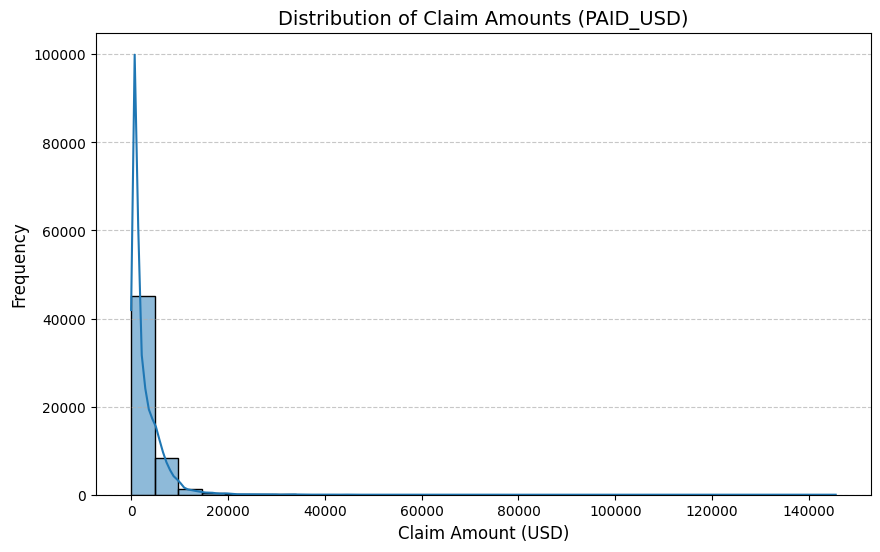

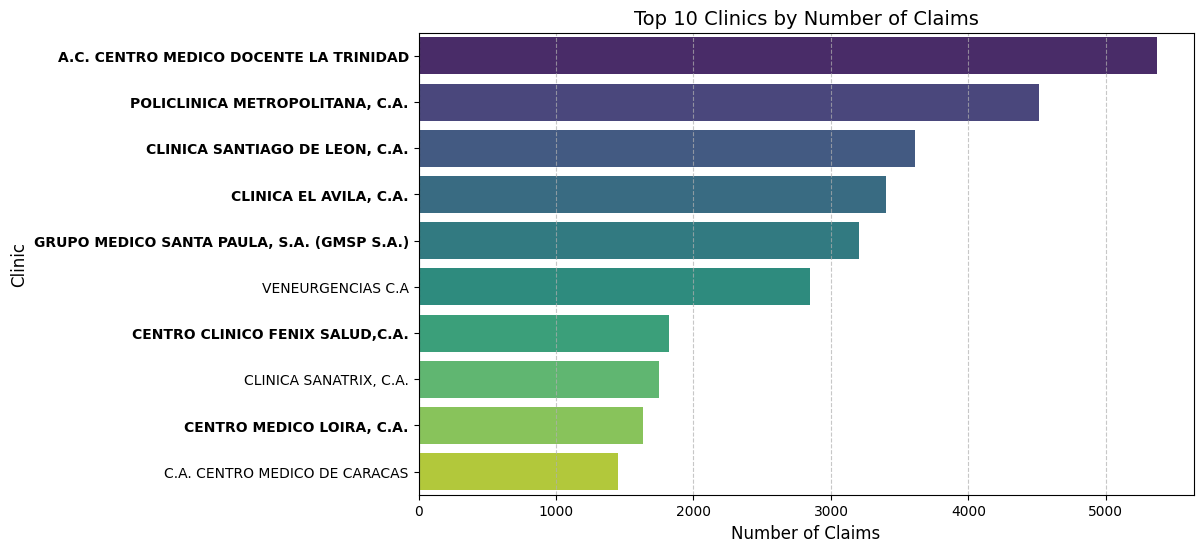

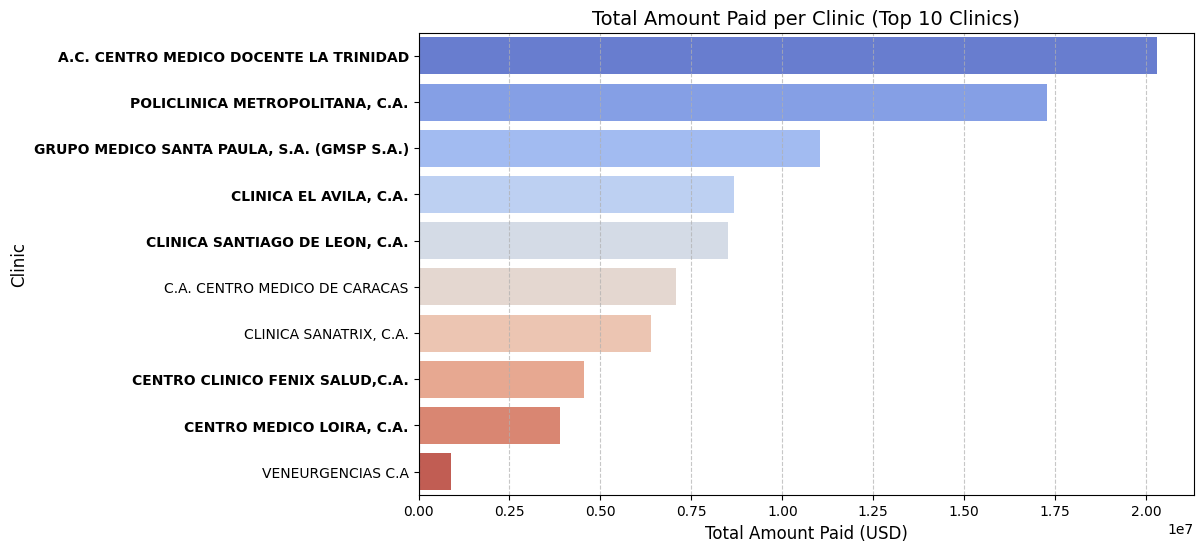

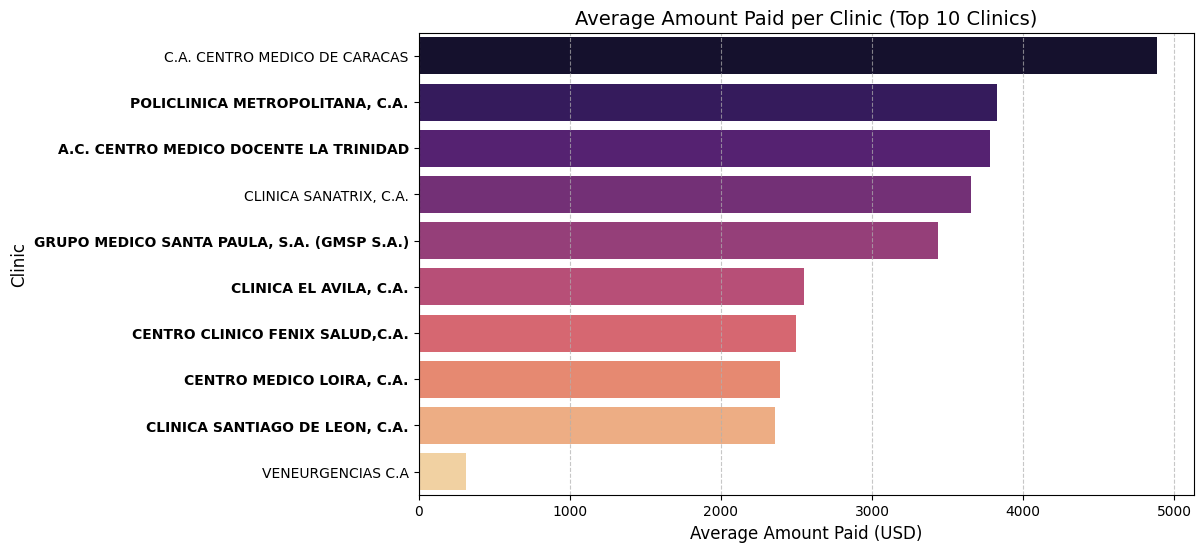

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to style y-axis labels with bold for clinics in red
def style_yaxis_labels(ax, clinics_in_red):
    for label in ax.get_yticklabels():
        clinic = label.get_text()
        if clinic in clinics_in_red:
            label.set_fontweight('bold')  # Make the font bold
        else:
            label.set_fontweight('normal')  # Default font weight

# List of clinics in red
clinics_in_red = set(CLINICS_IN_RED.keys())

# Distribution of Claim Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_aggregated['PAID_USD'], bins=30, kde=True)
plt.title('Distribution of Claim Amounts (PAID_USD)', fontsize=14)
plt.xlabel('Claim Amount (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Number of Claims per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
top_clinics = df_aggregated['CLINIC'].value_counts().head(10)
ax = sns.barplot(x=top_clinics.values, y=top_clinics.index, palette="viridis", hue=None)
style_yaxis_labels(ax, clinics_in_red)
plt.title('Top 10 Clinics by Number of Claims', fontsize=14)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Total Amount Paid per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
total_paid = df_aggregated[df_aggregated['CLINIC'].isin(top_clinics.index)].groupby('CLINIC', observed=False)['PAID_USD'].sum().sort_values(ascending=False)
ax = sns.barplot(x=total_paid.values, y=total_paid.index, palette="coolwarm", hue=None)
style_yaxis_labels(ax, clinics_in_red)
plt.title('Total Amount Paid per Clinic (Top 10 Clinics)', fontsize=14)
plt.xlabel('Total Amount Paid (USD)', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Average Amount Paid per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
average_paid = df_aggregated[df_aggregated['CLINIC'].isin(top_clinics.index)].groupby('CLINIC', observed=False)['PAID_USD'].mean().sort_values(ascending=False)
ax = sns.barplot(x=average_paid.values, y=average_paid.index, palette="magma", hue=None)
style_yaxis_labels(ax, clinics_in_red)
plt.title('Average Amount Paid per Clinic (Top 10 Clinics)', fontsize=14)
plt.xlabel('Average Amount Paid (USD)', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [34]:
# Top 10 procedures
top_procedures = df_normalized['PROCEDURE'].value_counts().head(13)
print("Top 13 Procedures (first 3 are too broad to categorize):")
for procedure, count in top_procedures.items():
    total_amount = df_normalized[df_normalized['PROCEDURE'] == procedure]['PAID_USD'].sum()
    avg_amount = df_normalized[df_normalized['PROCEDURE'] == procedure]['PAID_USD'].mean()
    print(f"\n{procedure}")
    print(f"  Claims: {count:,}")
    print(f"  Total Amount: ${total_amount:,.2f}")
    print(f"  Average Amount: ${avg_amount:,.2f}")


Top 13 Procedures (first 3 are too broad to categorize):

TRATAMIENTO MEDICO AMBULATORIO
  Claims: 43,047
  Total Amount: $26,003,656.00
  Average Amount: $604.08

TRATAMIENTO MEDICO CON HOSPITALIZACION
  Claims: 23,954
  Total Amount: $45,086,924.00
  Average Amount: $1,882.23

TRATAMIENTO MEDICO CON PROCEDIMIENTO NO BAREMIZADO
  Claims: 5,356
  Total Amount: $15,587,523.00
  Average Amount: $2,910.29

Cesárea
  Claims: 2,314
  Total Amount: $4,736,421.00
  Average Amount: $2,046.85

Facomulsificación + LIO
  Claims: 1,876
  Total Amount: $1,828,675.00
  Average Amount: $974.77

Facoemulsificación de Catarata con Implante de LIO Monofocal
  Claims: 1,133
  Total Amount: $1,166,055.00
  Average Amount: $1,029.17

Colecistectomia Laparoscopica
  Claims: 1,057
  Total Amount: $2,559,794.00
  Average Amount: $2,421.75

 Esguince Tobillo
  Claims: 683
  Total Amount: $391,677.00
  Average Amount: $573.47

Apendicectomía Laparoscópica
  Claims: 528
  Total Amount: $1,421,497.00
  Average Am

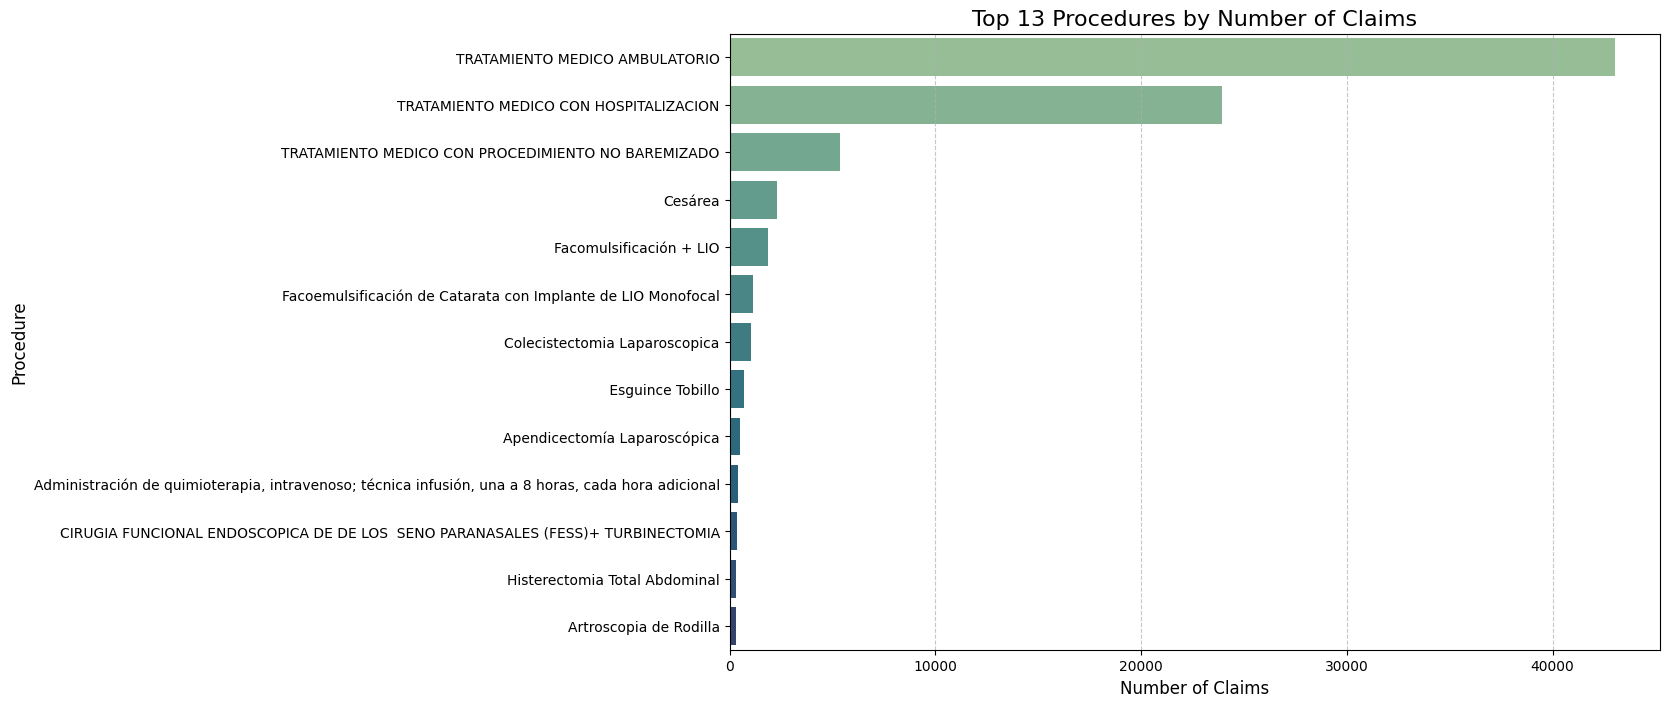

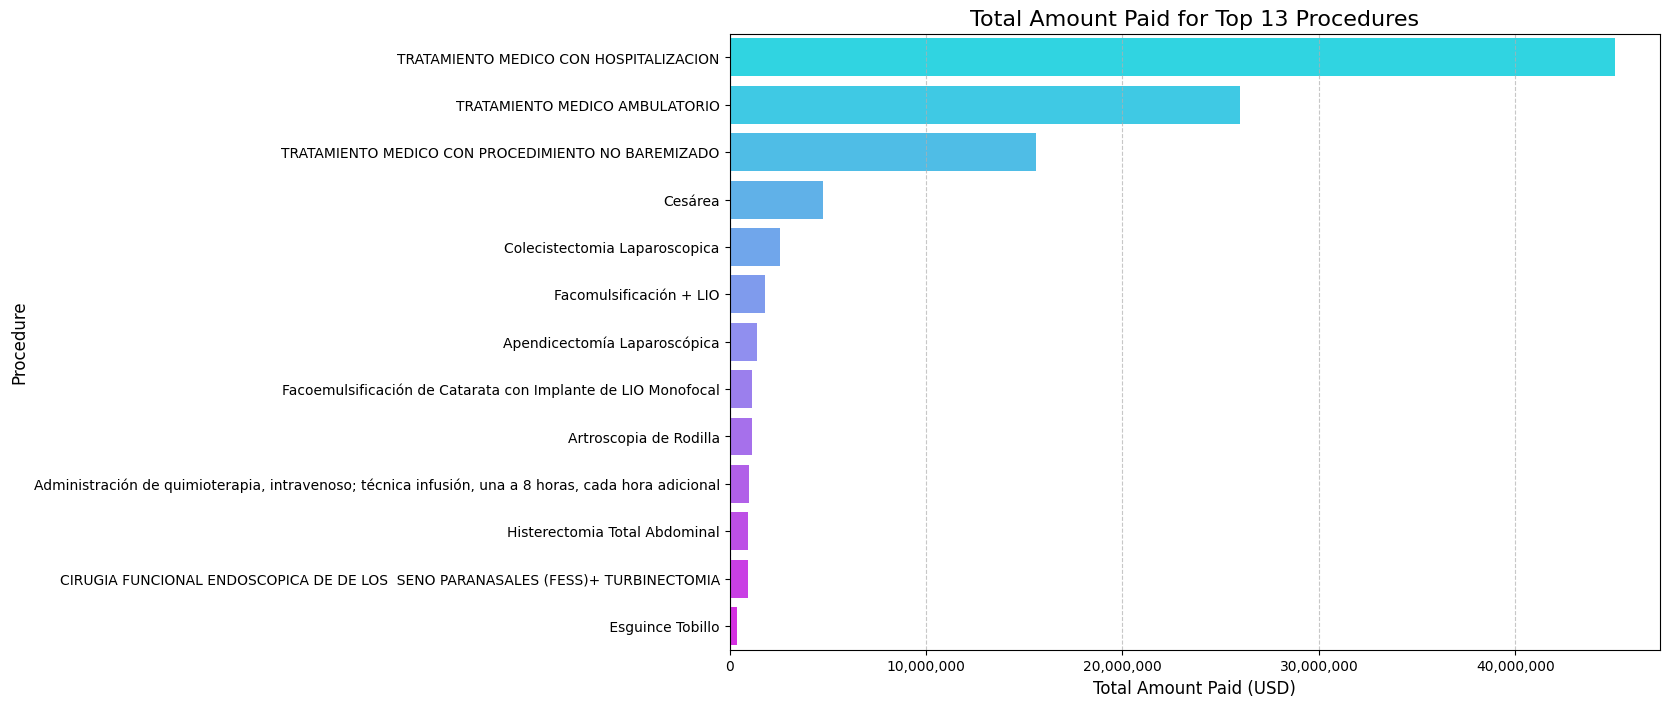

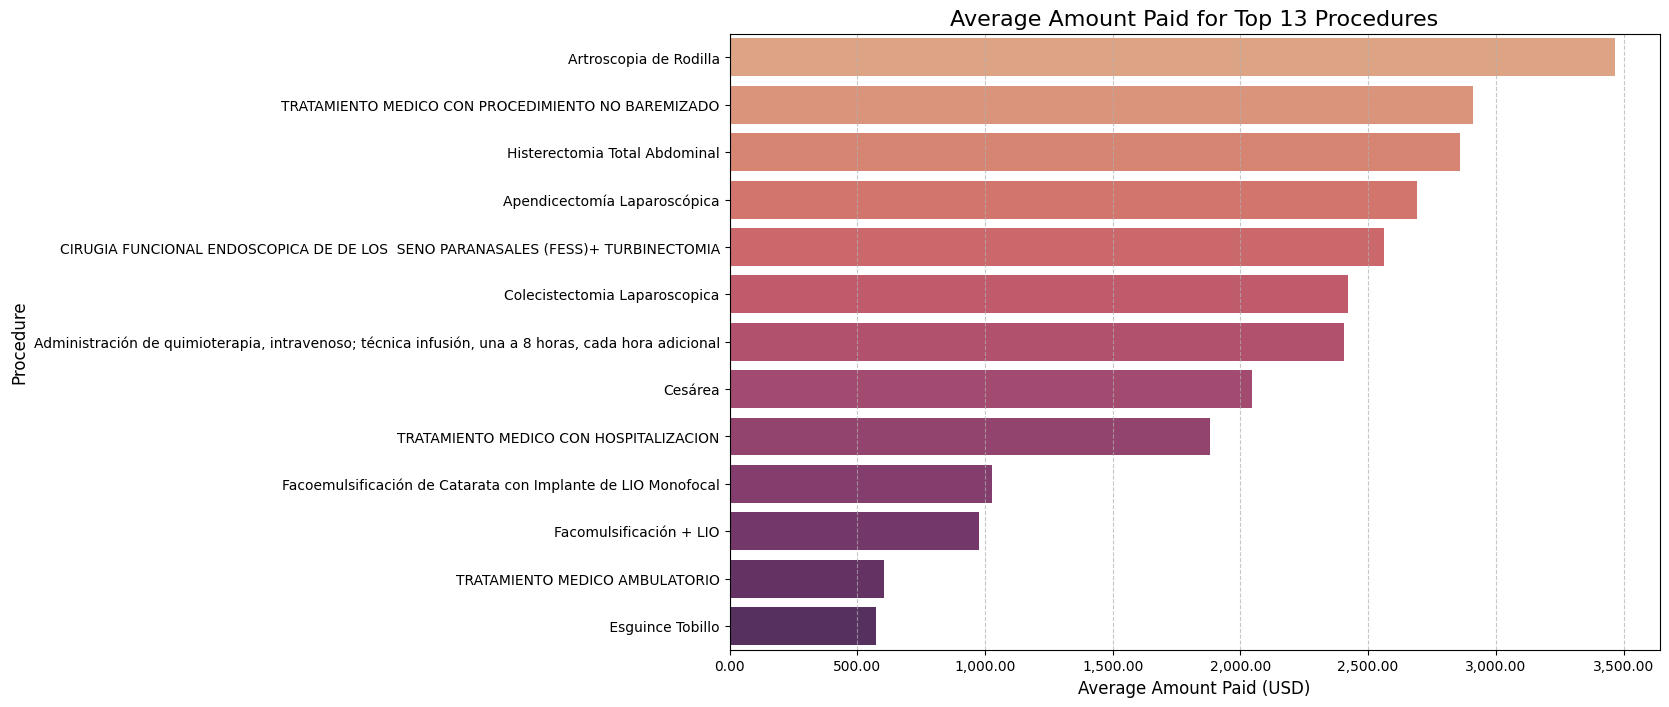

In [35]:
# Bar Chart for Top 13 Procedures by Number of Claims
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_procedures.values,
    y=top_procedures.index,
    palette="crest"
)
plt.title('Top 13 Procedures by Number of Claims', fontsize=16)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Bar Chart for Total Amount Paid for Top 13 Procedures
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 8))
total_amount_procedures = df_normalized[df_normalized['PROCEDURE'].isin(top_procedures.index)] \
    .groupby('PROCEDURE', observed=False)['PAID_USD'].sum().sort_values(ascending=False)
sns.barplot(
    x=total_amount_procedures.values,
    y=total_amount_procedures.index,
    palette="cool"
)
plt.title('Total Amount Paid for Top 13 Procedures', fontsize=16)
plt.xlabel('Total Amount Paid (USD)', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

# Bar Chart for Average Amount Paid for Top 13 Procedures
plt.figure(figsize=(12, 8))
average_amount_procedures = df_normalized[df_normalized['PROCEDURE'].isin(top_procedures.index)] \
    .groupby('PROCEDURE', observed=False)['PAID_USD'].mean().sort_values(ascending=False)
sns.barplot(
    x=average_amount_procedures.values,
    y=average_amount_procedures.index,
    palette="flare"
)
plt.title('Average Amount Paid for Top 13 Procedures', fontsize=16)
plt.xlabel('Average Amount Paid (USD)', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.show()

### 1.2 - Network vs Non-Network Overview
- Number of claims
- Paid amount (totals and mean/median by claim)

In [36]:
# Network statistics
df_aggregated['IN_RED'] = df_aggregated['IN_RED'].astype('category')  # Convert to category
in_red_stats = df_aggregated.groupby('IN_RED', observed=False).agg({
    'ID': 'count',
    'PAID_USD': ['sum', 'mean', 'median']
}).round(2)

print("Network vs Non-Network Statistics:")
for network_status in [True, False]:
    status_label = "In-Network" if network_status else "Out-of-Network"
    subset = df_aggregated[df_aggregated['IN_RED'] == network_status]
    
    if len(subset) > 0:
        print(f"\n{status_label}:")
        print(f"  Number of Claims: {len(subset):,}")
        print(f"  Total Amount: ${subset['PAID_USD'].sum():,.2f}")
        print(f"  Average Amount: ${subset['PAID_USD'].mean():,.2f}")
        print(f"  Median Amount: ${subset['PAID_USD'].median():,.2f}")
    else:
        print(f"\n{status_label}: No claims found")

Network vs Non-Network Statistics:

In-Network:
  Number of Claims: 3,868
  Total Amount: $10,411,725.00
  Average Amount: $2,691.76
  Median Amount: $1,346.00

Out-of-Network:
  Number of Claims: 51,849
  Total Amount: $148,929,805.00
  Average Amount: $2,872.38
  Median Amount: $1,388.00


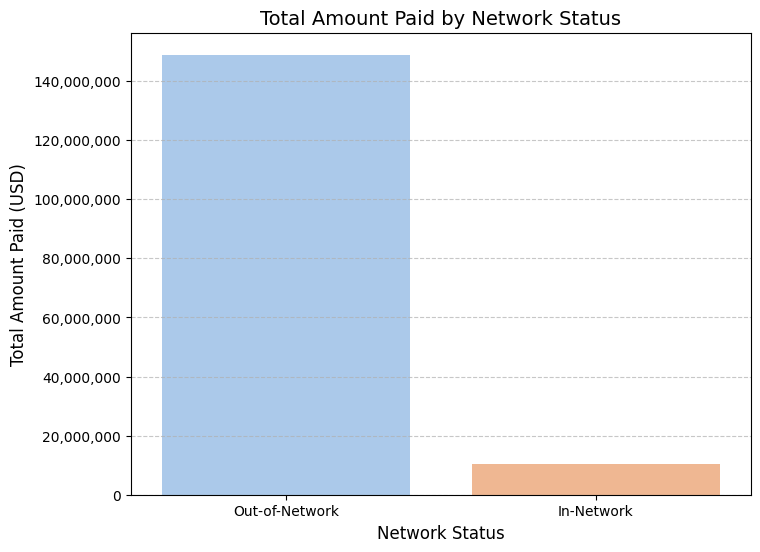

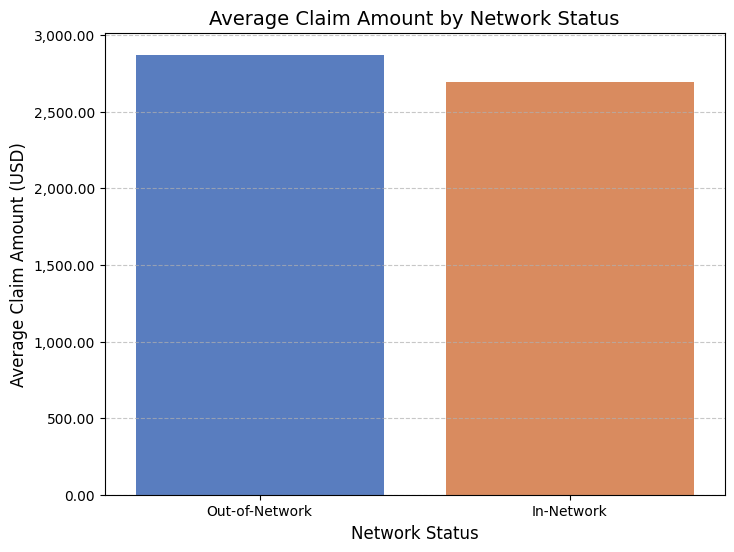

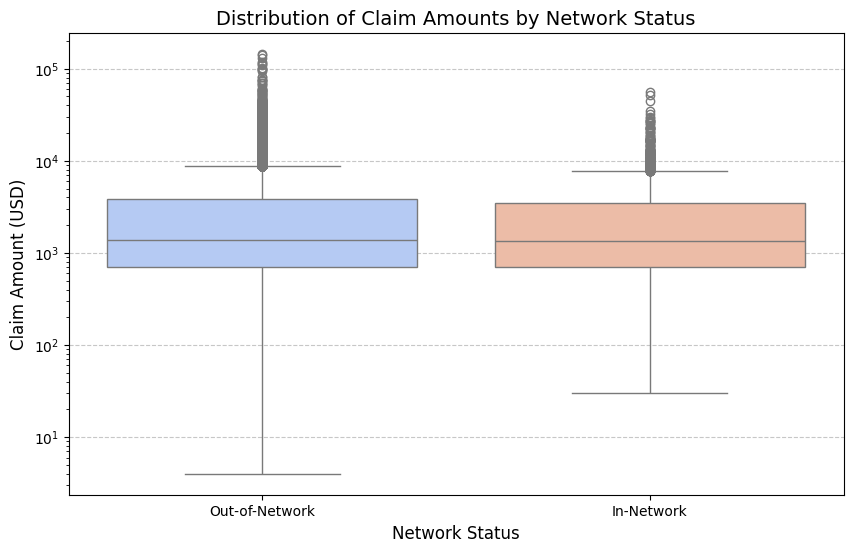

In [37]:
# Bar Chart for Total Amount Paid by Network Status
plt.figure(figsize=(8, 6))
network_stats = df_aggregated.groupby('IN_RED', observed=False)['PAID_USD'].sum().reset_index()
network_stats['IN_RED'] = network_stats['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.barplot(
    x='IN_RED',
    y='PAID_USD',
    data=network_stats,
    palette='pastel'
)
plt.title('Total Amount Paid by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Total Amount Paid (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar Chart for Average Claim Amount by Network Status
plt.figure(figsize=(8, 6))
avg_network_stats = df_aggregated.groupby('IN_RED', observed=False)['PAID_USD'].mean().reset_index()
avg_network_stats['IN_RED'] = avg_network_stats['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.barplot(
    x='IN_RED',
    y='PAID_USD',
    data=avg_network_stats,
    palette='muted'
)
plt.title('Average Claim Amount by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Average Claim Amount (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Box Plot for Distribution of Claim Amounts by Network Status
plt.figure(figsize=(10, 6))
df_aggregated['Network_Status'] = df_aggregated['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.boxplot(
    x='Network_Status',
    y='PAID_USD',
    data=df_aggregated,
    palette='coolwarm'
)
plt.title('Distribution of Claim Amounts by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Claim Amount (USD)', fontsize=12)
plt.yscale('log')  # Used log scale for better visualization of skewed data
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1.3 - Monthly Trends
- Claims and amount (total, mean/median) for last 6 months

In [38]:
# Monthly trends
monthly_trends = df_aggregated.set_index('DATE').resample('ME').agg({
    'ID': 'count',
    'PAID_USD': ['sum', 'mean']
}).round(2)

print("Monthly Trends (Last 6 months):")
for date, stats in monthly_trends.tail(6).iterrows():
    print(f"\n{date.strftime('%B %Y')}:")
    print(f"  Claims: {stats['ID']['count']:,}")
    print(f"  Total Amount: ${stats['PAID_USD']['sum']:,.2f}")
    print(f"  Average Amount: ${stats['PAID_USD']['mean']:,.2f}")

Monthly Trends (Last 6 months):

January 2024:
  Claims: 3,308.0
  Total Amount: $8,389,960.00
  Average Amount: $2,536.26

February 2024:
  Claims: 3,115.0
  Total Amount: $8,181,427.00
  Average Amount: $2,626.46

March 2024:
  Claims: 3,363.0
  Total Amount: $8,627,445.00
  Average Amount: $2,565.40

April 2024:
  Claims: 3,364.0
  Total Amount: $9,130,479.00
  Average Amount: $2,714.17

May 2024:
  Claims: 2,727.0
  Total Amount: $6,247,726.00
  Average Amount: $2,291.06

June 2024:
  Claims: 2.0
  Total Amount: $7,182.00
  Average Amount: $3,591.00


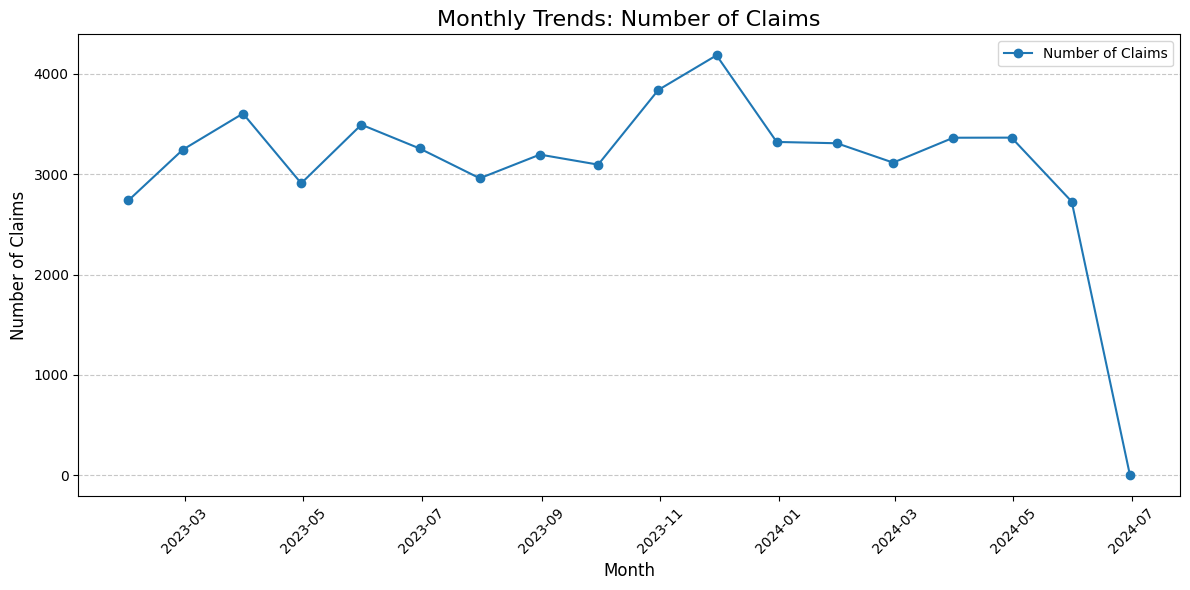

<Figure size 1200x600 with 0 Axes>

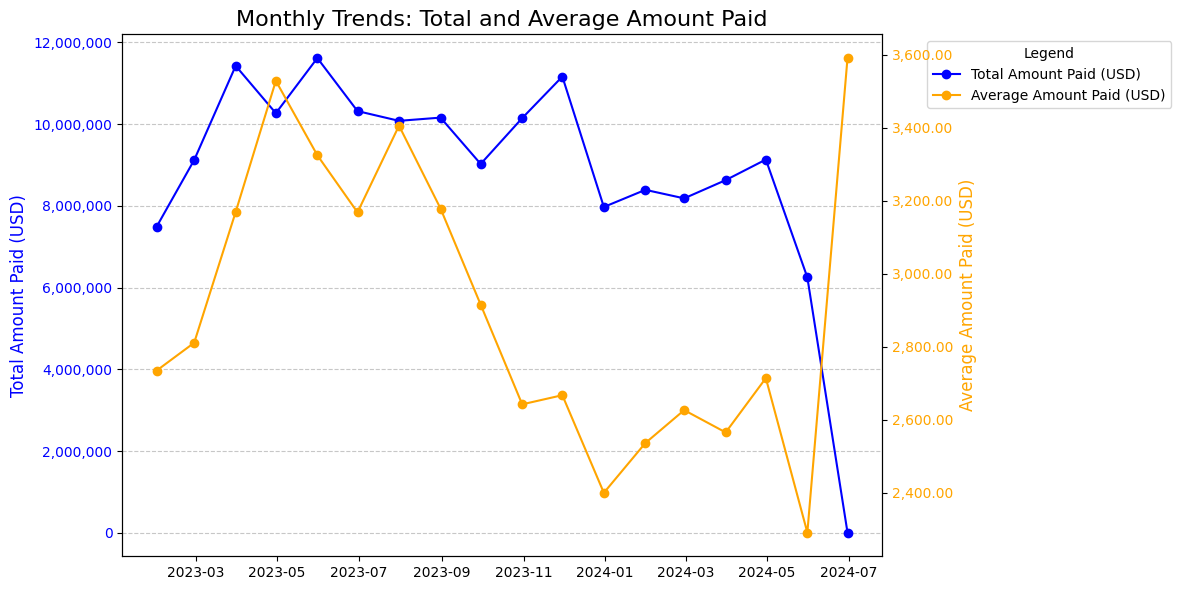

In [66]:
# Line Chart for Monthly Claims Count
plt.figure(figsize=(12, 6))
monthly_claims = monthly_trends['ID']['count']
plt.plot(monthly_claims.index, monthly_claims.values, marker='o', label='Number of Claims')
plt.title('Monthly Trends: Number of Claims', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Line Chart for Total and Average Amount Paid (USD) by Month
plt.figure(figsize=(12, 6))
monthly_total_paid = monthly_trends['PAID_USD']['sum']
monthly_avg_paid = monthly_trends['PAID_USD']['mean']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Total Amount Paid
ax1.plot(monthly_total_paid.index, monthly_total_paid.values, marker='o', label='Total Amount Paid (USD)', color='blue')
ax1.set_ylabel('Total Amount Paid (USD)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Secondary y-axis: Average Amount Paid
ax2 = ax1.twinx()
line2, = ax2.plot(monthly_avg_paid.index, monthly_avg_paid.values, marker='o', 
                  label='Average Amount Paid (USD)', color='orange')
ax2.set_ylabel('Average Amount Paid (USD)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))

# Collect handles and labels from both axes for the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines += [line2]
labels += labels2

# Add the combined legend
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

# Titles and x-axis
plt.title('Monthly Trends: Total and Average Amount Paid', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **2 - Network vs Non-Network In Depth**
- Overperformer, As expected, Underperformer categorization
- Comparison by tiers


In [40]:
# Part 1.2: Before vs. After Joining Network (Normalized Time Frames)

# Define analysis window (3 months before and after joining)
ANALYSIS_WINDOW = pd.DateOffset(months=3)


def analyze_clinic_performance(clinic_name):
    """
    Analyzes clinic performance before and after joining network.
    Compares same months across years to account for seasonality.
    """
    
    clinic_data = CLINICS_IN_RED.get(clinic_name)
    if not clinic_data:
        return None
        
    # Get join date
    join_dates = [pd.to_datetime(d) for d in clinic_data['join_date'].values() if d]
    if not join_dates:
        return None
    join_date = min(join_dates)
    
    # Get clinic's last transaction date in 2024
    clinic_last_date = df_aggregated[
        (df_aggregated['CLINIC'] == clinic_name) & 
        (df_aggregated['DATE'].dt.year == 2024)
    ]['DATE'].max()
    
    if pd.isnull(clinic_last_date):
        return None
    
    # Define comparison periods
    after_start = join_date
    after_end = clinic_last_date
    
    before_start = after_start - pd.DateOffset(years=1)
    before_end = after_end - pd.DateOffset(years=1)
    
    # Get months to compare
    comparison_months = pd.date_range(
        after_start, 
        after_end, 
        freq='ME'
    ).month.unique()
    
    # Create masks for before and after periods
    after_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= after_start) &
        (df_aggregated['DATE'] <= after_end)
    )
    
    before_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= before_start) &
        (df_aggregated['DATE'] <= before_end) &
        (df_aggregated['DATE'].dt.month.isin(comparison_months))  # Same months as after period
    )
    
    # Get claims for both periods
    after_claims = df_aggregated[after_mask].copy()
    before_claims = df_aggregated[before_mask].copy()
    
    if len(after_claims) == 0 or len(before_claims) == 0:
        return None
        
    # Calculate metrics for each period
    metrics = {}
    for period, claims in [('Before', before_claims), ('After', after_claims)]:
        metrics[period] = {
            'Claims': len(claims),
            'Claims per Month': len(claims) / len(comparison_months),
            'Median Price': claims['PAID_USD'].median(),
            'Mean Price': claims['PAID_USD'].mean(),
            'Total Paid': claims['PAID_USD'].sum(),
            'Unique Procedures': len(set([item for sublist in claims['PROCEDURES'] for item in sublist])),
            'Procedures per Claim': claims['PROCEDURES'].apply(len).mean()
        }
    
    # Calculate percentage changes
    changes = {
        'Claims Volume': ((metrics['After']['Claims'] / metrics['Before']['Claims']) - 1) * 100,
        'Monthly Claims': ((metrics['After']['Claims per Month'] / metrics['Before']['Claims per Month']) - 1) * 100,
        'Median Price': ((metrics['After']['Median Price'] / metrics['Before']['Median Price']) - 1) * 100,
        'Mean Price': ((metrics['After']['Mean Price'] / metrics['Before']['Mean Price']) - 1) * 100,
        'Procedures per Claim': ((metrics['After']['Procedures per Claim'] / metrics['Before']['Procedures per Claim']) - 1) * 100
    }
    
    # Determine performance category based on changes
    score = 0
    
    # Volume score: +1 if volume increased by 10%, -1 if decreased by 10%
    score += 1 if changes['Monthly Claims'] > 10 else -1 if changes['Monthly Claims'] < -10 else 0
    
    # Price score: +1 if prices decreased by 5%, -1 if increased by 5%
    avg_price_change = (changes['Median Price'] + changes['Mean Price']) / 2
    score += 1 if avg_price_change < -5 else -1 if avg_price_change > 5 else 0
    
    # Procedure diversity score: +1 if procedures per claim increased by 10%, -1 if decreased by 10%
    score += 1 if changes['Procedures per Claim'] > 10 else -1 if changes['Procedures per Claim'] < -10 else 0
    
    performance = "Overperformer" if score >= 2 else "Underperformer" if score <= -2 else "As Expected"
    
    return {
        'metrics': metrics,
        'changes': changes,
        'performance': performance,
        'tier': clinic_data.get('tier', 'Unknown'),
        'comparison_period': {
            'before': (before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')),
            'after': (after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')),
            'months_compared': sorted(comparison_months.tolist())
        }
    }

# Analyze all clinics
clinic_performances = {}
for clinic in CLINICS_IN_RED:
    result = analyze_clinic_performance(clinic)
    if result:
        clinic_performances[clinic] = result

# Print results
print("\nClinic Performance Analysis After Joining Network")
print("-" * 50)

# Group clinics by performance category
performance_categories = {
    "Overperformer": [],
    "As Expected": [],
    "Underperformer": []
}

for clinic, data in clinic_performances.items():
    performance_categories[data['performance']].append((clinic, data))

# Print results by category
for category, clinics in performance_categories.items():
    print(f"\n{category} Clinics ({len(clinics)}):")
    for clinic, data in clinics:
        print(f"\n  {clinic} (Tier {data['tier']}):")
        for metric, value in data['changes'].items():
            print(f"    {metric}: {value:+.1f}%")


Clinic Performance Analysis After Joining Network
--------------------------------------------------

Overperformer Clinics (6):

  CENTRO CLINICO FENIX SALUD,C.A. (Tier C):
    Claims Volume: +75.9%
    Monthly Claims: +75.9%
    Median Price: -23.4%
    Mean Price: -11.7%
    Procedures per Claim: +7.5%

  CENTRO DIAGNOSTICO DOCENTE LAS MERCEDES, C.A. (Tier B):
    Claims Volume: +2.8%
    Monthly Claims: +2.8%
    Median Price: -35.0%
    Mean Price: -17.8%
    Procedures per Claim: +15.7%

  GRUPO MEDICO LAS ACACIAS, C.A. (Tier B):
    Claims Volume: +256.2%
    Monthly Claims: +256.2%
    Median Price: -63.2%
    Mean Price: -43.7%
    Procedures per Claim: +2.4%

  SERVICIOS CLINICOS SANTA MONICA, C.A. (Tier B):
    Claims Volume: +113.2%
    Monthly Claims: +113.2%
    Median Price: -8.6%
    Mean Price: -15.1%
    Procedures per Claim: +4.4%

  SERVICIOS CLINICOS U.M.Q. NUEVA CARACAS , C.A (Tier C):
    Claims Volume: +46.3%
    Monthly Claims: +46.3%
    Median Price: -2.9%
 

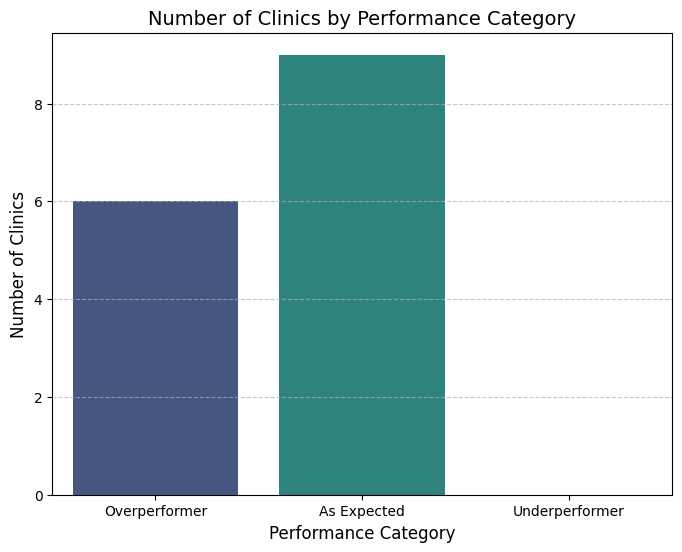

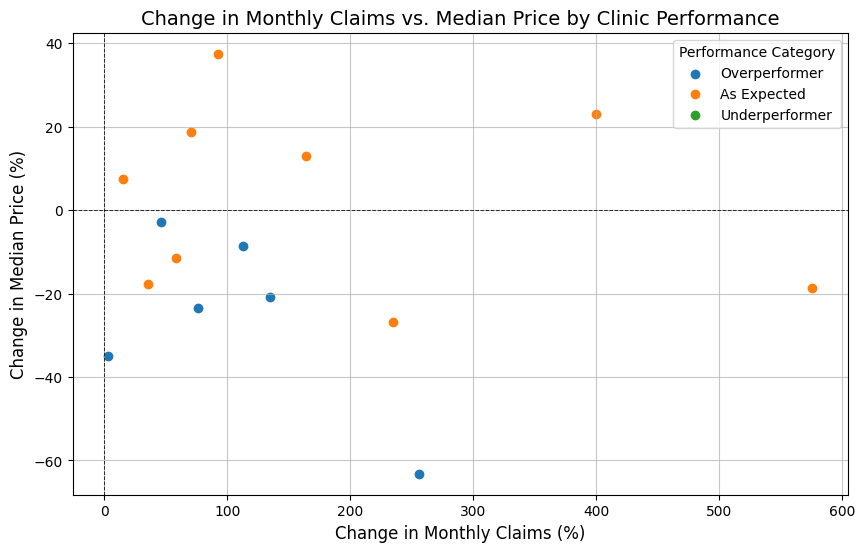

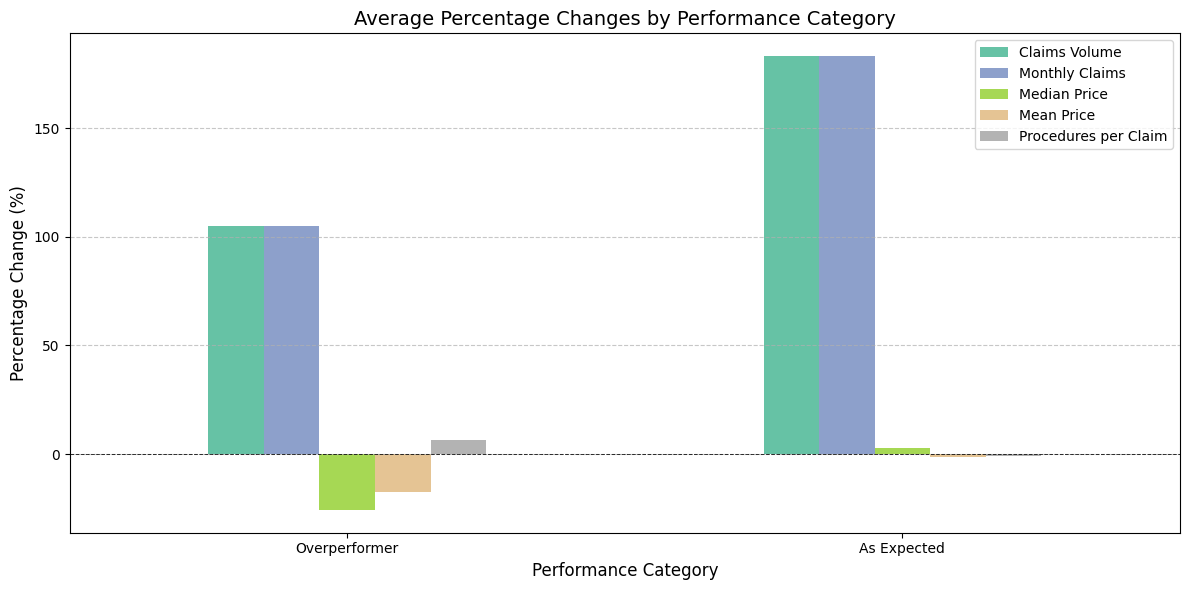

In [41]:
# 1. Bar Chart for Performance Categories
plt.figure(figsize=(8, 6))
performance_counts = {k: len(v) for k, v in performance_categories.items()}
sns.barplot(
    x=list(performance_counts.keys()),
    y=list(performance_counts.values()),
    palette="viridis"
)
plt.title('Number of Clinics by Performance Category', fontsize=14)
plt.xlabel('Performance Category', fontsize=12)
plt.ylabel('Number of Clinics', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Scatter Plot for Percentage Changes in Median Price vs. Monthly Claims
plt.figure(figsize=(10, 6))
for category, clinics in performance_categories.items():
    changes = [data['changes'] for _, data in clinics]
    plt.scatter(
        [c['Monthly Claims'] for c in changes],
        [c['Median Price'] for c in changes],
        label=category
    )
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.title('Change in Monthly Claims vs. Median Price by Clinic Performance', fontsize=14)
plt.xlabel('Change in Monthly Claims (%)', fontsize=12)
plt.ylabel('Change in Median Price (%)', fontsize=12)
plt.legend(title='Performance Category')
plt.grid(alpha=0.7)
plt.show()

# 3. Bar Chart for Average Changes by Performance Category
changes_summary = {}
for category, clinics in performance_categories.items():
    if len(clinics) > 0:
        avg_changes = pd.DataFrame([data['changes'] for _, data in clinics]).mean()
        changes_summary[category] = avg_changes

changes_df = pd.DataFrame(changes_summary).T

changes_df.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title('Average Percentage Changes by Performance Category', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.xlabel('Performance Category', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
#### Part 1.3: Comparison Among Clinics In vs. Out of Network By Tier

# Function to get tier metrics
def calculate_tier_metrics(tier):
    """Calculates metrics for in-network and out-of-network clinics within a tier"""
    
    # Get in-network clinics for this tier
    in_network = [
        clinic for clinic, data in CLINICS_IN_RED.items() 
        if data.get('tier') == tier
    ]
    
    # Get out-of-network comparison clinics for this tier
    out_network = TIER_COMPARSION.get(tier, [])
    
    # Initialize results
    results = {'IN': {}, 'OUT': {}}
    
    # Calculate metrics for each network status
    for status, clinics in [('IN', in_network), ('OUT', out_network)]:
        if not clinics:
            continue
            
        # Get claims for these clinics
        claims = df_aggregated[df_aggregated['CLINIC'].isin(clinics)]
        
        if len(claims) == 0:
            continue
            
        # Calculate metrics
        results[status] = {
            'Claims Volume': len(claims),
            'Clinics': len(clinics),
            'Claims per Clinic': len(claims) / len(clinics),
            'Median Price': claims['PAID_USD'].median(),
            'Mean Price': claims['PAID_USD'].mean(),
            'Price Range': f"${claims['PAID_USD'].min():,.2f} - ${claims['PAID_USD'].max():,.2f}",
            'Unique Procedures per Clinic': len(set([item for sublist in claims['PROCEDURES'] for item in sublist])) / len(clinics),
            'Procedures per Claim': claims['PROCEDURES'].apply(len).mean()
        }
    
    return results

# Get unique tiers from CLINICS_IN_RED
tiers = set()
for clinic_data in CLINICS_IN_RED.values():
    if 'tier' in clinic_data:
        tiers.add(clinic_data['tier'])

# Analyze each tier
print("\nTier-Based Performance Comparison")
print("-" * 50)

for tier in sorted(tiers):
    print(f"\nTier {tier}:")
    metrics = calculate_tier_metrics(tier)
    
    for network_status in ['IN', 'OUT']:
        if not metrics[network_status]:
            print(f"  No {network_status}-Network data available")
            continue
            
        print(f"\n  {network_status}-Network Metrics:")
        for metric, value in metrics[network_status].items():
            if isinstance(value, (int, float)):
                print(f"    {metric}: {value:,.2f}")
            else:
                print(f"    {metric}: {value}")
                
    # Calculate and print differences if both IN and OUT data exist
    if metrics['IN'] and metrics['OUT']:
        print("\n  Comparison (IN vs OUT):")
        comparable_metrics = [
            'Claims per Clinic',
            'Median Price',
            'Mean Price',
            'Procedures per Claim'
        ]
        
        for metric in comparable_metrics:
            diff_pct = ((metrics['IN'][metric] / metrics['OUT'][metric]) - 1) * 100
            print(f"    {metric}: {diff_pct:+.1f}%")


Tier-Based Performance Comparison
--------------------------------------------------

Tier A:

  IN-Network Metrics:
    Claims Volume: 17,507.00
    Clinics: 5.00
    Claims per Clinic: 3,501.40
    Median Price: 1,612.00
    Mean Price: 3,517.71
    Price Range: $12.00 - $145,506.00
    Unique Procedures per Clinic: 69.80
    Procedures per Claim: 1.86

  OUT-Network Metrics:
    Claims Volume: 2,518.00
    Clinics: 2.00
    Claims per Clinic: 1,259.00
    Median Price: 2,953.50
    Mean Price: 4,797.38
    Price Range: $75.00 - $116,685.00
    Unique Procedures per Clinic: 78.00
    Procedures per Claim: 2.46

  Comparison (IN vs OUT):
    Claims per Clinic: +178.1%
    Median Price: -45.4%
    Mean Price: -26.7%
    Procedures per Claim: -24.4%

Tier B:

  IN-Network Metrics:
    Claims Volume: 9,359.00
    Clinics: 11.00
    Claims per Clinic: 850.82
    Median Price: 1,220.00
    Mean Price: 2,390.17
    Price Range: $31.00 - $130,000.00
    Unique Procedures per Clinic: 22.36
 

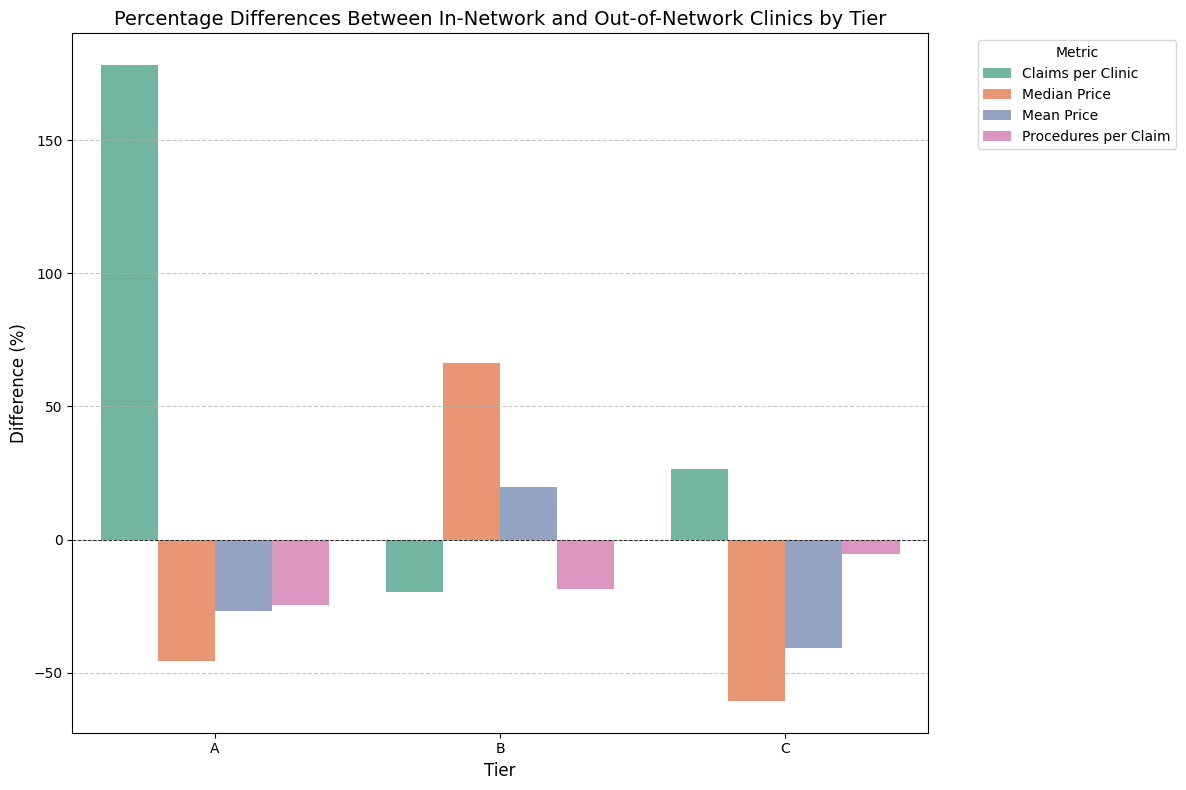

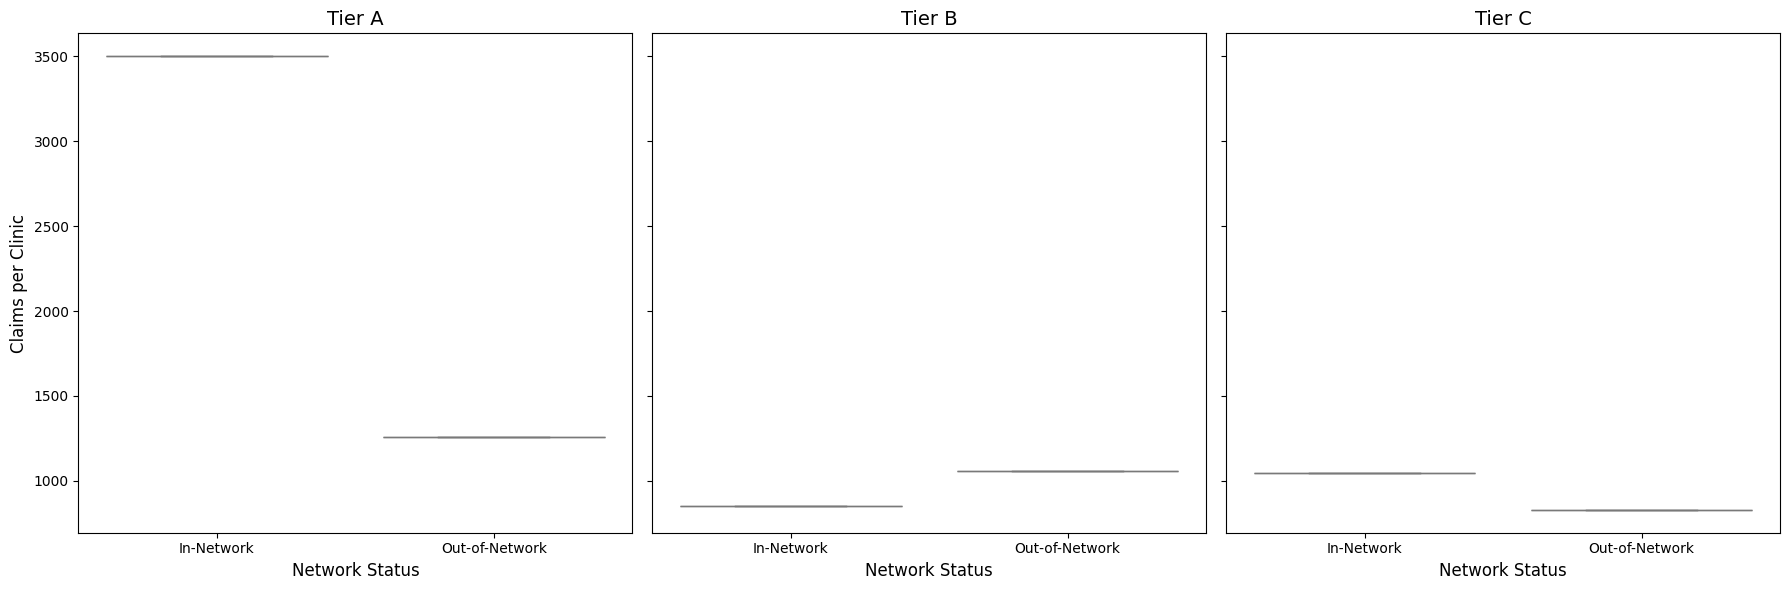

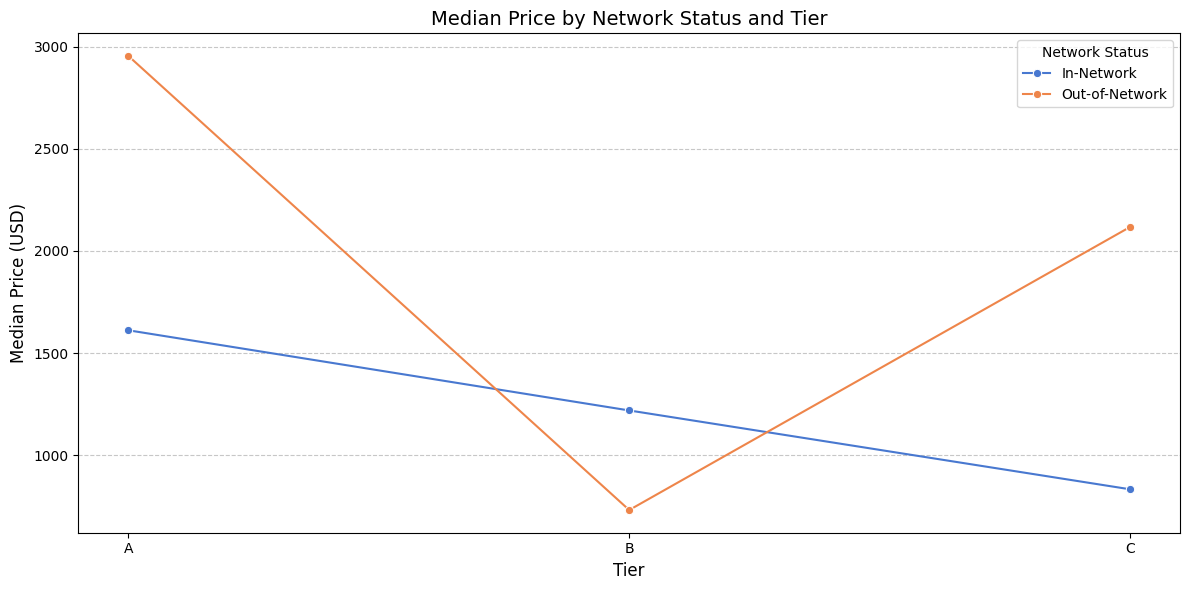

In [43]:
# Initialize data storage for visualization
comparison_data = []

# Iterate over each tier to collect comparison data
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    
    if metrics['IN'] and metrics['OUT']:
        for metric in ['Claims per Clinic', 'Median Price', 'Mean Price', 'Procedures per Claim']:
            in_metric = metrics['IN'][metric]
            out_metric = metrics['OUT'][metric]
            diff_pct = ((in_metric / out_metric) - 1) * 100
            
            comparison_data.append({
                'Tier': tier,
                'Metric': metric,
                'Difference (%)': diff_pct
            })

# Convert comparison data to DataFrame for visualization
comparison_df = pd.DataFrame(comparison_data)

# 1. Bar Chart for Percentage Differences by Metric Across Tiers
plt.figure(figsize=(12, 8))
sns.barplot(
    data=comparison_df,
    x='Tier',
    y='Difference (%)',
    hue='Metric',
    palette='Set2'
)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.title('Percentage Differences Between In-Network and Out-of-Network Clinics by Tier', fontsize=14)
plt.xlabel('Tier', fontsize=12)
plt.ylabel('Difference (%)', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Box Plot for Claims per Clinic by Network Status
tier_network_data = []

# Collect data for box plot
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    for network_status in ['IN', 'OUT']:
        if metrics[network_status]:
            tier_network_data.append({
                'Tier': tier,
                'Network': 'In-Network' if network_status == 'IN' else 'Out-of-Network',
                'Claims per Clinic': metrics[network_status]['Claims per Clinic']
            })

tier_network_df = pd.DataFrame(tier_network_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, tier in enumerate(tier_network_df['Tier'].unique()):
    subset = tier_network_df[tier_network_df['Tier'] == tier]
    sns.boxplot(
        data=subset,
        x='Network',
        y='Claims per Clinic',
        hue='Network',
        palette='coolwarm',
        ax=axes[idx],
        dodge=False,
        legend=False
    )
    axes[idx].set_title(f'Tier {tier}', fontsize=14)
    axes[idx].set_xlabel('Network Status', fontsize=12)
    if idx == 0:
        axes[idx].set_ylabel('Claims per Clinic', fontsize=12)

plt.tight_layout()
plt.show()

# 3. Line Plot for Median Price Across Tiers
median_price_data = []

# Collect data for line plot
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    for network_status in ['IN', 'OUT']:
        if metrics[network_status]:
            median_price_data.append({
                'Tier': tier,
                'Network': 'In-Network' if network_status == 'IN' else 'Out-of-Network',
                'Median Price': metrics[network_status]['Median Price']
            })

median_price_df = pd.DataFrame(median_price_data)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=median_price_df,
    x='Tier',
    y='Median Price',
    hue='Network',
    marker='o',
    palette='muted'
)
plt.title('Median Price by Network Status and Tier', fontsize=14)
plt.xlabel('Tier', fontsize=12)
plt.ylabel('Median Price (USD)', fontsize=12)
plt.legend(title='Network Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [58]:
df_aggregated['PCNT_PAID_BY_INSURANCE'] = df_aggregated['PAID_USD'] / df_aggregated['CLAIM_USD'] * 100

def analyze_correlations(df_aggregated):
    # Define columns we want to analyze
    available_columns = ['PAID_USD', 'PROCEDURE_CLUSTER', 'PCNT_PAID_BY_INSURANCE']
    
    # Calculate correlations only for available columns
    corr_matrix = df_aggregated[available_columns].corr()
    
    print("\nCorrelation Analysis:")
    print("-" * 50)
    print(corr_matrix.round(3))
        
    print("\nKey Insights:")
    
    # Create a multi-level column structure for cluster statistics
    cluster_stats_columns = pd.MultiIndex.from_product([['PAID_USD', 'PCNT_PAID_BY_INSURANCE'], ['mean', 'median']])
    cluster_stats = pd.DataFrame(columns=cluster_stats_columns)
    
    # Fill payment statistics
    payment_stats = df_aggregated.groupby('PROCEDURE_CLUSTER')['PAID_USD'].agg(['mean', 'median']).round(2)
    cluster_stats[('PAID_USD', 'mean')] = payment_stats['mean']
    cluster_stats[('PAID_USD', 'median')] = payment_stats['median']
    
    # Fill PCNT_PAID_BY_INSURANCE statistics
    coverage_stats = df_aggregated.groupby('PROCEDURE_CLUSTER')['PCNT_PAID_BY_INSURANCE'].agg(['mean', 'median']).round(2)
    cluster_stats[('PCNT_PAID_BY_INSURANCE', 'mean')] = coverage_stats['mean']
    cluster_stats[('PCNT_PAID_BY_INSURANCE', 'median')] = coverage_stats['median']
    
    print("\nProcedure Cluster Statistics:")
    print(cluster_stats)
    
    # Remove zeros and create bins for PCNT_PAID_BY_INSURANCE
    valid_coverage = df_aggregated[df_aggregated['PCNT_PAID_BY_INSURANCE'] > 0]
    
    try:
        # Create bins with handling for duplicates
        df_aggregated['COVERAGE_BIN'] = pd.qcut(
            valid_coverage['PCNT_PAID_BY_INSURANCE'], 
            q=5, 
            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
            duplicates='drop'
        )
        
        coverage_bin_stats = df_aggregated.groupby('COVERAGE_BIN').agg({
            'PAID_USD': ['mean', 'median', 'count'],
            'PROCEDURE_CLUSTER': 'nunique'
        }).round(2)
        
        coverage_bin_stats.columns = [
            'Mean Payment', 'Median Payment', 'Claim Count', 
            'Unique Procedure Types'
        ]
        
        print("\nPayment Statistics by Percentage Paid by Insurance Level:")
        print(coverage_bin_stats)
        
        # Calculate price ratios (amount paid vs percentage paid by insurance) for non-zero values
        valid_coverage['PRICE_RATIO'] = (
            valid_coverage['PAID_USD'] / 
            valid_coverage['PCNT_PAID_BY_INSURANCE']
        )
        
        ratio_stats = valid_coverage.groupby('COVERAGE_BIN')['PRICE_RATIO'].agg([
            'mean', 'median'
        ]).round(3)
        
        print("\nPrice to Coverage Ratio by Coverage Level:")
        print(ratio_stats)
        
    except Exception as e:
        print(f"\nWarning: Could not complete percentage paid by insurance analysis: {str(e)}")
        print("This might be due to insufficient variation in coverage values.")
    
    # Return correlation matrix and data for visualization
    return corr_matrix, df_aggregated

# Apply clustering to procedures
procedure_clusters = cluster_procedures(df_aggregated['PROCEDURES'])
df_aggregated['PROCEDURE_CLUSTER'] = df_aggregated['PROCEDURES'].apply(
    lambda x: procedure_clusters.get(tuple(x), -1)
)

# Run correlation analysis
analyze_correlations(df_aggregated)


Correlation Analysis:
--------------------------------------------------
                        PAID_USD  PROCEDURE_CLUSTER  PCNT_PAID_BY_INSURANCE
PAID_USD                   1.000              0.123                  -0.003
PROCEDURE_CLUSTER          0.123              1.000                   0.003
PCNT_PAID_BY_INSURANCE    -0.003              0.003                   1.000

Key Insights:

Procedure Cluster Statistics:
                  PAID_USD          PCNT_PAID_BY_INSURANCE        
                      mean   median                   mean  median
PROCEDURE_CLUSTER                                                 
-1                2774.650 1299.500                 94.330  99.990
 0                4327.380 4421.000                 94.610 100.000
 1                1168.390  794.000                 95.610 100.000
 2                5898.000 4792.000                 96.750 100.000
 3                6071.060 4834.000                 95.030 100.000
 4                4110.040 2710.000     

(                        PAID_USD  PROCEDURE_CLUSTER  PCNT_PAID_BY_INSURANCE
 PAID_USD                   1.000              0.123                  -0.003
 PROCEDURE_CLUSTER          0.123              1.000                   0.003
 PCNT_PAID_BY_INSURANCE    -0.003              0.003                   1.000,
                                                       ID  \
 0      00673554EMBARAZO, PARTO Y PUERPERIOoctubre2023...   
 1             00673554NAUSEA Y VOMITOabril2023EMERGENCIA   
 2      069701191TRAUMATISMO SUPERFICIAL DE LA CADERA ...   
 3      090786255TUMOR MALIGNO DE LOS BRONQUIOS Y DEL ...   
 4      091139498FRACTURAS QUE AFECTAN MULTIPLES REGIO...   
 ...                                                  ...   
 55712  V999137TRAUMATISMO INTRACRANEALjunio2023EMERGE...   
 55713  V999963INFECCION VIRAL - COVID 19mayo2023EMERG...   
 55714  YC703579EMBARAZO, PARTO Y PUERPERIOnoviembre20...   
 55715          YC703579INFECCION VIRALmayo2024EMERGENCIA   
 55716       YC70357


Correlation Analysis:
--------------------------------------------------
                        PAID_USD  PROCEDURE_CLUSTER  PCNT_PAID_BY_INSURANCE
PAID_USD                   1.000              0.123                  -0.003
PROCEDURE_CLUSTER          0.123              1.000                   0.003
PCNT_PAID_BY_INSURANCE    -0.003              0.003                   1.000

Key Insights:

Procedure Cluster Statistics:
                  PAID_USD          PCNT_PAID_BY_INSURANCE        
                      mean   median                   mean  median
PROCEDURE_CLUSTER                                                 
-1                2774.650 1299.500                 94.330  99.990
 0                4327.380 4421.000                 94.610 100.000
 1                1168.390  794.000                 95.610 100.000
 2                5898.000 4792.000                 96.750 100.000
 3                6071.060 4834.000                 95.030 100.000
 4                4110.040 2710.000     

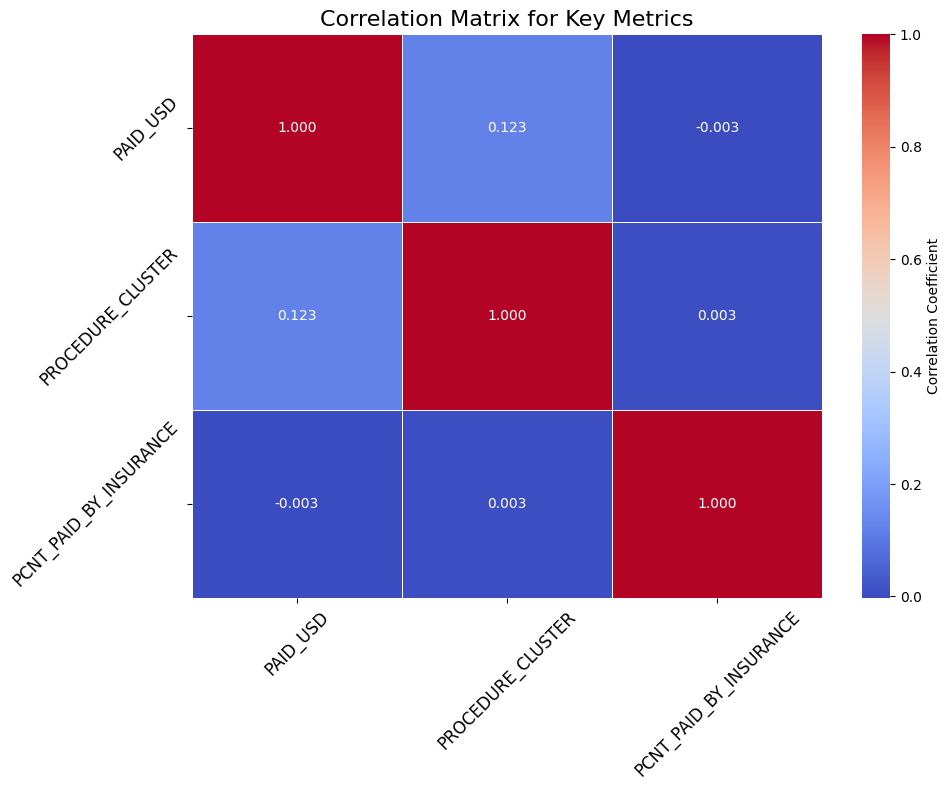

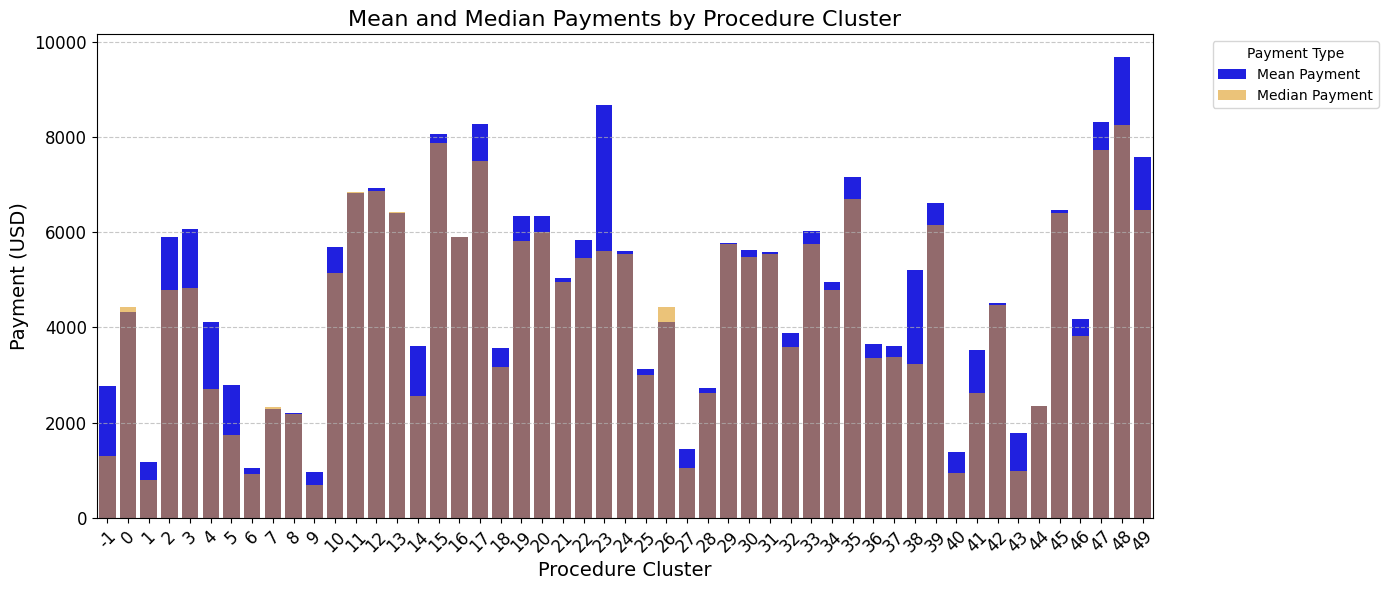

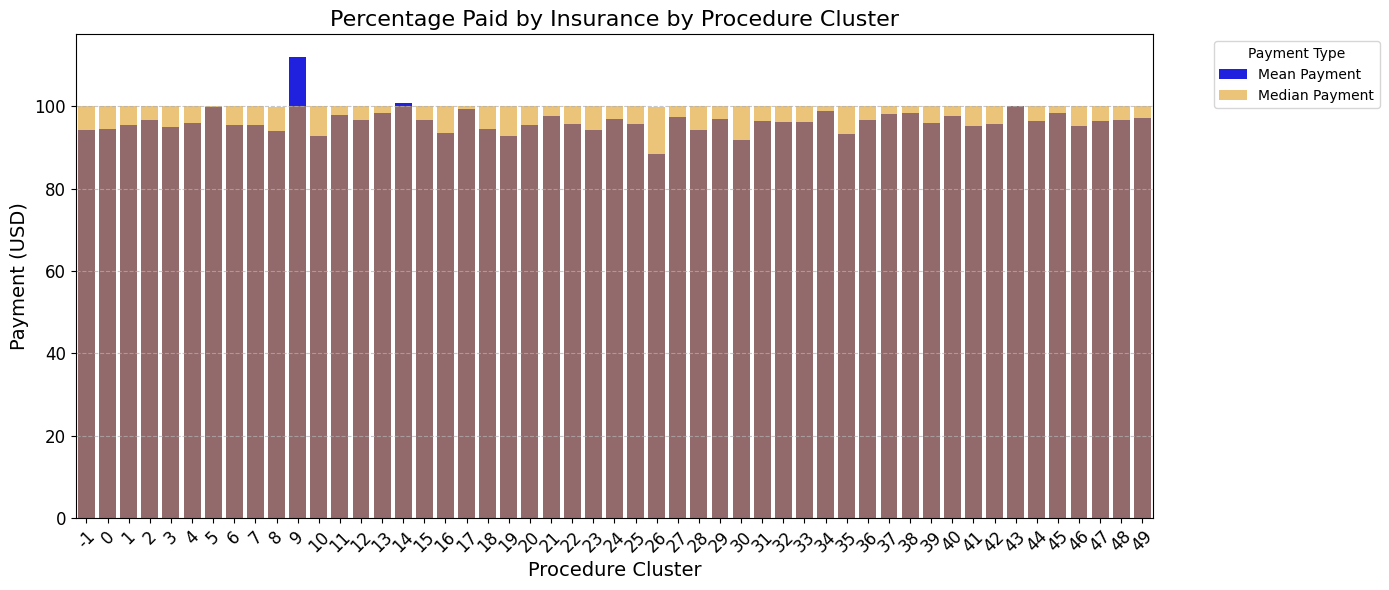

In [62]:
# Run correlation analysis and retrieve results
df_aggregated['PCNT_PAID_BY_INSURANCE'] = df_aggregated['PAID_USD'] / df_aggregated['CLAIM_USD'] * 100
corr_matrix, df_with_coverage = analyze_correlations(df_aggregated)

# Visualization for Correlation Analysis and Insurance Coverage Analysis

# 1. Heatmap for Correlation Matrix
# Visualizes correlations between PAID_USD, PROCEDURE_CLUSTER, and INSURANCE_COVERAGE
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix for Key Metrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# 2. Bar Chart for Procedure Cluster Statistics
# Displays mean and median payments by procedure cluster
cluster_stats = df_with_coverage.groupby('PROCEDURE_CLUSTER')['PAID_USD'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='mean',
    data=cluster_stats,
    color='blue',
    label='Mean Payment'
)
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='median',
    data=cluster_stats,
    color='orange',
    label='Median Payment',
    alpha=0.6
)
plt.title('Mean and Median Payments by Procedure Cluster', fontsize=16)
plt.xlabel('Procedure Cluster', fontsize=14)
plt.ylabel('Payment (USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

cluster_stats = df_aggregated.groupby('PROCEDURE_CLUSTER')['PCNT_PAID_BY_INSURANCE'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='mean',
    data=cluster_stats,
    color='blue',
    label='Mean Payment'
)
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='median',
    data=cluster_stats,
    color='orange',
    label='Median Payment',
    alpha=0.6
)
plt.title('Percentage Paid by Insurance by Procedure Cluster', fontsize=16)
plt.xlabel('Procedure Cluster', fontsize=14)
plt.ylabel('Payment (USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [46]:
### Part 2: Extended Analysis Using Additional Variables

def analyze_extended_metrics():
    """Comprehensive analysis using additional variables from original dataset"""
    
    # Read original dataset
    df_original = pd.read_csv('data.csv', encoding='utf-8', low_memory=False)
    
    # Merge with aggregated data
    df_extended = df_aggregated.merge(
        df_original[[
            'CONCATENADO',  # This is our ID
            'especialidad',
            'edad',
            'tipo de poliza',
            'Producto',
            'tratamiento',
            'sucursal',
            'Categoría',
            'ramo'
        ]],
        left_on='ID',
        right_on='CONCATENADO',
        how='left'
    ).rename(columns={
        'especialidad': 'SPECIALTY',
        'edad': 'AGE',
        'tipo de poliza': 'POLICY_TYPE',
        'Producto': 'PRODUCT',
        'tratamiento': 'TREATMENT',
        'sucursal': 'BRANCH',
        'Categoría': 'CATEGORY',
        'ramo': 'BUSINESS_LINE'
    })
    
    # Convert IN_RED to numeric (True -> 1, False -> 0)
    df_extended['IN_RED'] = df_extended['IN_RED'].astype(int)
    
    print("\nExtended Analysis Results")
    print("=" * 50)
    
    # 1. Medical Specialty Analysis
    print("\n1. Medical Specialty Analysis")
    print("-" * 30)
    
    # Count and financial metrics separately
    specialty_counts = df_extended.groupby('SPECIALTY', observed=False).size().sort_values(ascending=False)
    specialty_financials = df_extended.groupby('SPECIALTY', observed=False)['PAID_USD'].agg([
        'mean', 'median', 'std'
    ]).round(2)
    
    # Now IN_RED is numeric, so mean calculation will work
    specialty_network = df_extended.groupby('SPECIALTY', observed=False)['IN_RED'].mean().round(2)
    
    # Combine metrics
    specialty_metrics = pd.concat([
        specialty_counts.rename('count'),
        specialty_financials,
        specialty_network.rename('network_rate')
    ], axis=1)
    
    print("\nTop 10 Specialties by Volume:")
    print(specialty_metrics.head(10))
    
    # Network impact by specialty
    print("\nNetwork Impact Analysis:")
    network_impact = df_extended.pivot_table(
        values='PAID_USD',
        index='SPECIALTY',
        columns='IN_RED',
        aggfunc=['mean', 'count']
    ).round(2)
    
    # Calculate price changes where we have both in and out of network data
    network_impact['price_change_pct'] = (
        (network_impact[('mean', 1)] - network_impact[('mean', 0)]) / 
        network_impact[('mean', 0)] * 100
    ).round(2)
    
    print("\nTop 5 Specialties with Largest Price Reductions in Network:")
    valid_changes = network_impact[
        network_impact['price_change_pct'].notna() & 
        (network_impact[('count', 1)] >= 10) &  # Minimum sample size
        (network_impact[('count', 0)] >= 10)
    ]
    print(valid_changes.nlargest(5, 'price_change_pct')[['price_change_pct']])
    
    # 2. Demographics Analysis
    print("\n2. Demographics Analysis")
    print("-" * 30)
    
    # Age analysis
    df_extended['AGE'] = pd.to_numeric(df_extended['AGE'], errors='coerce')
    age_bins = [0, 18, 35, 50, 65, float('inf')]
    age_labels = ['0-18', '19-35', '36-50', '51-65', '65+']
    df_extended['AGE_GROUP'] = pd.cut(df_extended['AGE'], bins=age_bins, labels=age_labels)
    
    age_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('AGE_GROUP', observed=False).size(),
        'Avg_Cost': df_extended.groupby('AGE_GROUP', observed=False)['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('AGE_GROUP', observed=False)['IN_RED'].mean().round(2),
        'Avg_Procedures': df_extended.groupby('AGE_GROUP', observed=False)['PROCEDURES'].apply(
            lambda x: np.mean([len(p) for p in x])
        ).round(2)
    })
    
    print("\nMetrics by Age Group:")
    print(age_metrics)
    
    # 3. Treatment Analysis
    print("\n3. Treatment Pattern Analysis")
    print("-" * 30)
    
    # Spanish stop words list
    spanish_stop_words = [
        'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas'
    ]
    
    # Cluster treatments using NLP
    vectorizer = TfidfVectorizer(
        stop_words=spanish_stop_words,
        ngram_range=(1, 2),
        max_features=1000
    )
    
    # Handle NaN values in treatments
    treatments_text = df_extended['TREATMENT'].fillna('')
    treatment_vectors = vectorizer.fit_transform(treatments_text)
    
    n_clusters = min(len(df_extended) // 20, 30)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_extended['TREATMENT_CLUSTER'] = kmeans.fit_predict(treatment_vectors)
    
    # Calculate metrics by treatment cluster
    treatment_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('TREATMENT_CLUSTER', observed=False).size(),
        'Avg_Cost': df_extended.groupby('TREATMENT_CLUSTER', observed=False)['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('TREATMENT_CLUSTER', observed=False)['IN_RED'].mean().round(2),
        'Common_Treatments': df_extended.groupby('TREATMENT_CLUSTER', observed=False)['TREATMENT'].agg(
            lambda x: x.value_counts().head(3).index.tolist()
        )
    })
    
    print("\nTop 5 Treatment Clusters by Volume:")
    print(treatment_metrics.nlargest(5, 'Claims'))
    
    # 4. Business Line Analysis
    print("\n4. Business Line Analysis")
    print("-" * 30)
    
    business_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('BUSINESS_LINE', observed=False).size(),
        'Avg_Cost': df_extended.groupby('BUSINESS_LINE', observed=False)['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('BUSINESS_LINE', observed=False)['IN_RED'].mean().round(2),
        'Avg_Procedures': df_extended.groupby('BUSINESS_LINE', observed=False)['PROCEDURES'].apply(
            lambda x: np.mean([len(p) for p in x])
        ).round(2)
    })
    
    print("\nMetrics by Business Line:")
    print(business_metrics)
    
    # 5. Cross-Analysis
    print("\n5. Cross-Analysis: Average Cost by Specialty and Business Line")
    print("-" * 30)
    
    cross_analysis = pd.pivot_table(
        df_extended,
        values='PAID_USD',
        index='SPECIALTY',
        columns='BUSINESS_LINE',
        aggfunc='mean'
    ).round(2)
    
    print("\nTop 5 Most Expensive Specialty-Business Line Combinations:")
    flat_cross = cross_analysis.unstack()
    print(flat_cross.nlargest(5))
    
    return {
        'specialty_metrics': specialty_metrics,
        'age_metrics': age_metrics,
        'treatment_metrics': treatment_metrics,
        'business_metrics': business_metrics,
        'cross_analysis': cross_analysis,
        'df_extended': df_extended
    }

# Run the extended analysis
extended_results = analyze_extended_metrics()


Extended Analysis Results

1. Medical Specialty Analysis
------------------------------

Top 10 Specialties by Volume:
                           count     mean   median       std  network_rate
SPECIALTY                                                                 
MEDICINA INTERNA           42212 1972.320  903.500  3574.240         0.070
TRAUMATOLOGIA              21036 4046.000 2809.000  4350.560         0.070
CIRUGIA GENERAL             7661 5022.630 4709.000  3608.470         0.080
PEDIATRIA                   7157 2711.090  990.000  6648.990         0.090
OFTALMOLOGIA                4313 2299.340 2285.000   893.890         0.120
OBSTETRICIA                 3530 4033.380 4212.000  1489.440         0.040
OTORRINOLARINGOLOGIA        3192 4278.470 4666.000  2670.680         0.080
ONCOLOGIA                   2842 7641.480 4855.000 10889.230         0.060
UROLOGIA                    2517 5127.220 4363.000  3892.250         0.090
TRAUMATOLOGIA ORTOPEDISTA   2107 4357.420 2484.000  520

/Users/logankm/CS/data_mining_final_project/venv/lib/python3.9/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



Top 5 Treatment Clusters by Volume:
                   Claims  Avg_Cost  Network_Rate  \
TREATMENT_CLUSTER                                   
1                   51916  3689.720         0.000   
0                   34559  1189.610         0.110   
2                   10548  6841.010         0.100   
3                    8952  4260.490         0.100   
5                    5809  3896.550         0.210   

                                              Common_Treatments  
TREATMENT_CLUSTER                                                
1                                                            []  
0                                     [Tratamiento Ambulatorio]  
2                  [Tratamiento Quirúrgico con Hospitalización]  
3                             [Tratamiento con Hospitalización]  
5                          [Tratamiento Quirúrgico Ambulatorio]  

4. Business Line Analysis
------------------------------

Metrics by Business Line:
               Claims  Avg_Cost  Network_Rat


Extended Analysis Results

1. Medical Specialty Analysis
------------------------------

Top 10 Specialties by Volume:
                           count     mean   median       std  network_rate
SPECIALTY                                                                 
MEDICINA INTERNA           42212 1972.320  903.500  3574.240         0.070
TRAUMATOLOGIA              21036 4046.000 2809.000  4350.560         0.070
CIRUGIA GENERAL             7661 5022.630 4709.000  3608.470         0.080
PEDIATRIA                   7157 2711.090  990.000  6648.990         0.090
OFTALMOLOGIA                4313 2299.340 2285.000   893.890         0.120
OBSTETRICIA                 3530 4033.380 4212.000  1489.440         0.040
OTORRINOLARINGOLOGIA        3192 4278.470 4666.000  2670.680         0.080
ONCOLOGIA                   2842 7641.480 4855.000 10889.230         0.060
UROLOGIA                    2517 5127.220 4363.000  3892.250         0.090
TRAUMATOLOGIA ORTOPEDISTA   2107 4357.420 2484.000  520

/Users/logankm/CS/data_mining_final_project/venv/lib/python3.9/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



Top 5 Treatment Clusters by Volume:
                   Claims  Avg_Cost  Network_Rate  \
TREATMENT_CLUSTER                                   
1                   51916  3689.720         0.000   
0                   34559  1189.610         0.110   
2                   10548  6841.010         0.100   
3                    8952  4260.490         0.100   
5                    5809  3896.550         0.210   

                                              Common_Treatments  
TREATMENT_CLUSTER                                                
1                                                            []  
0                                     [Tratamiento Ambulatorio]  
2                  [Tratamiento Quirúrgico con Hospitalización]  
3                             [Tratamiento con Hospitalización]  
5                          [Tratamiento Quirúrgico Ambulatorio]  

4. Business Line Analysis
------------------------------

Metrics by Business Line:
               Claims  Avg_Cost  Network_Rat

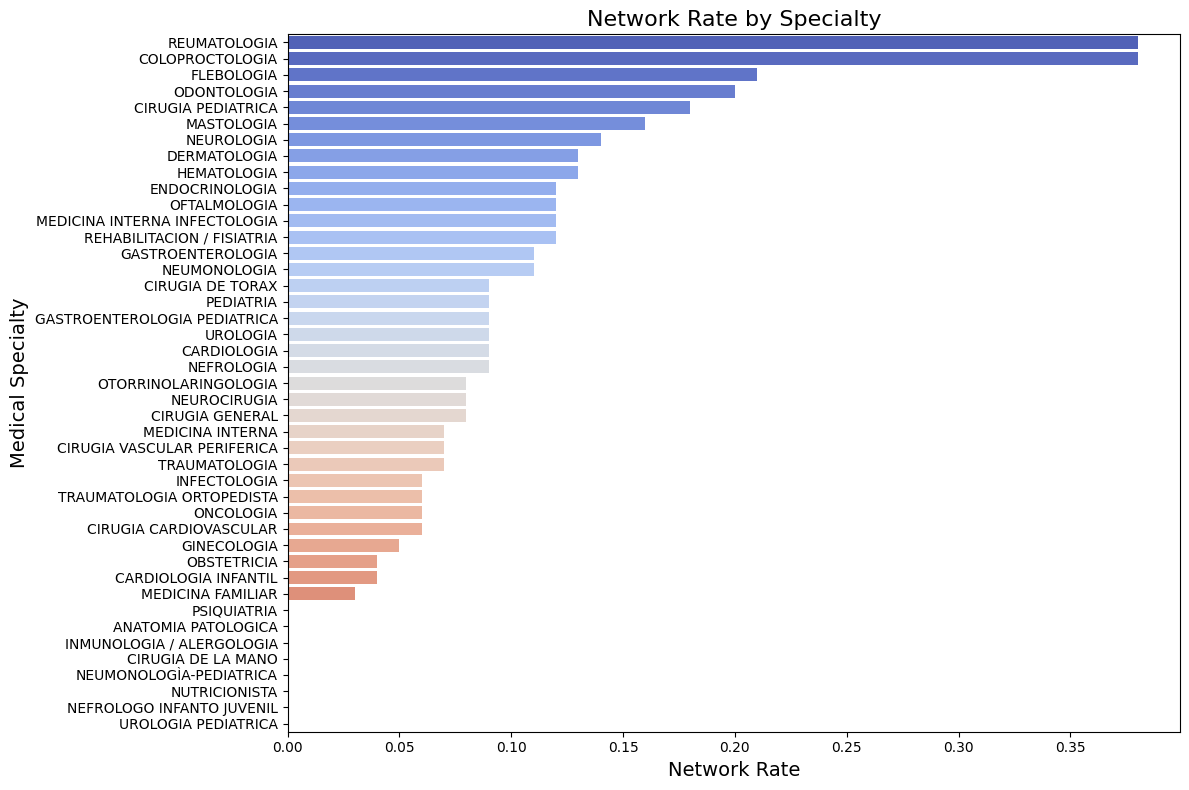

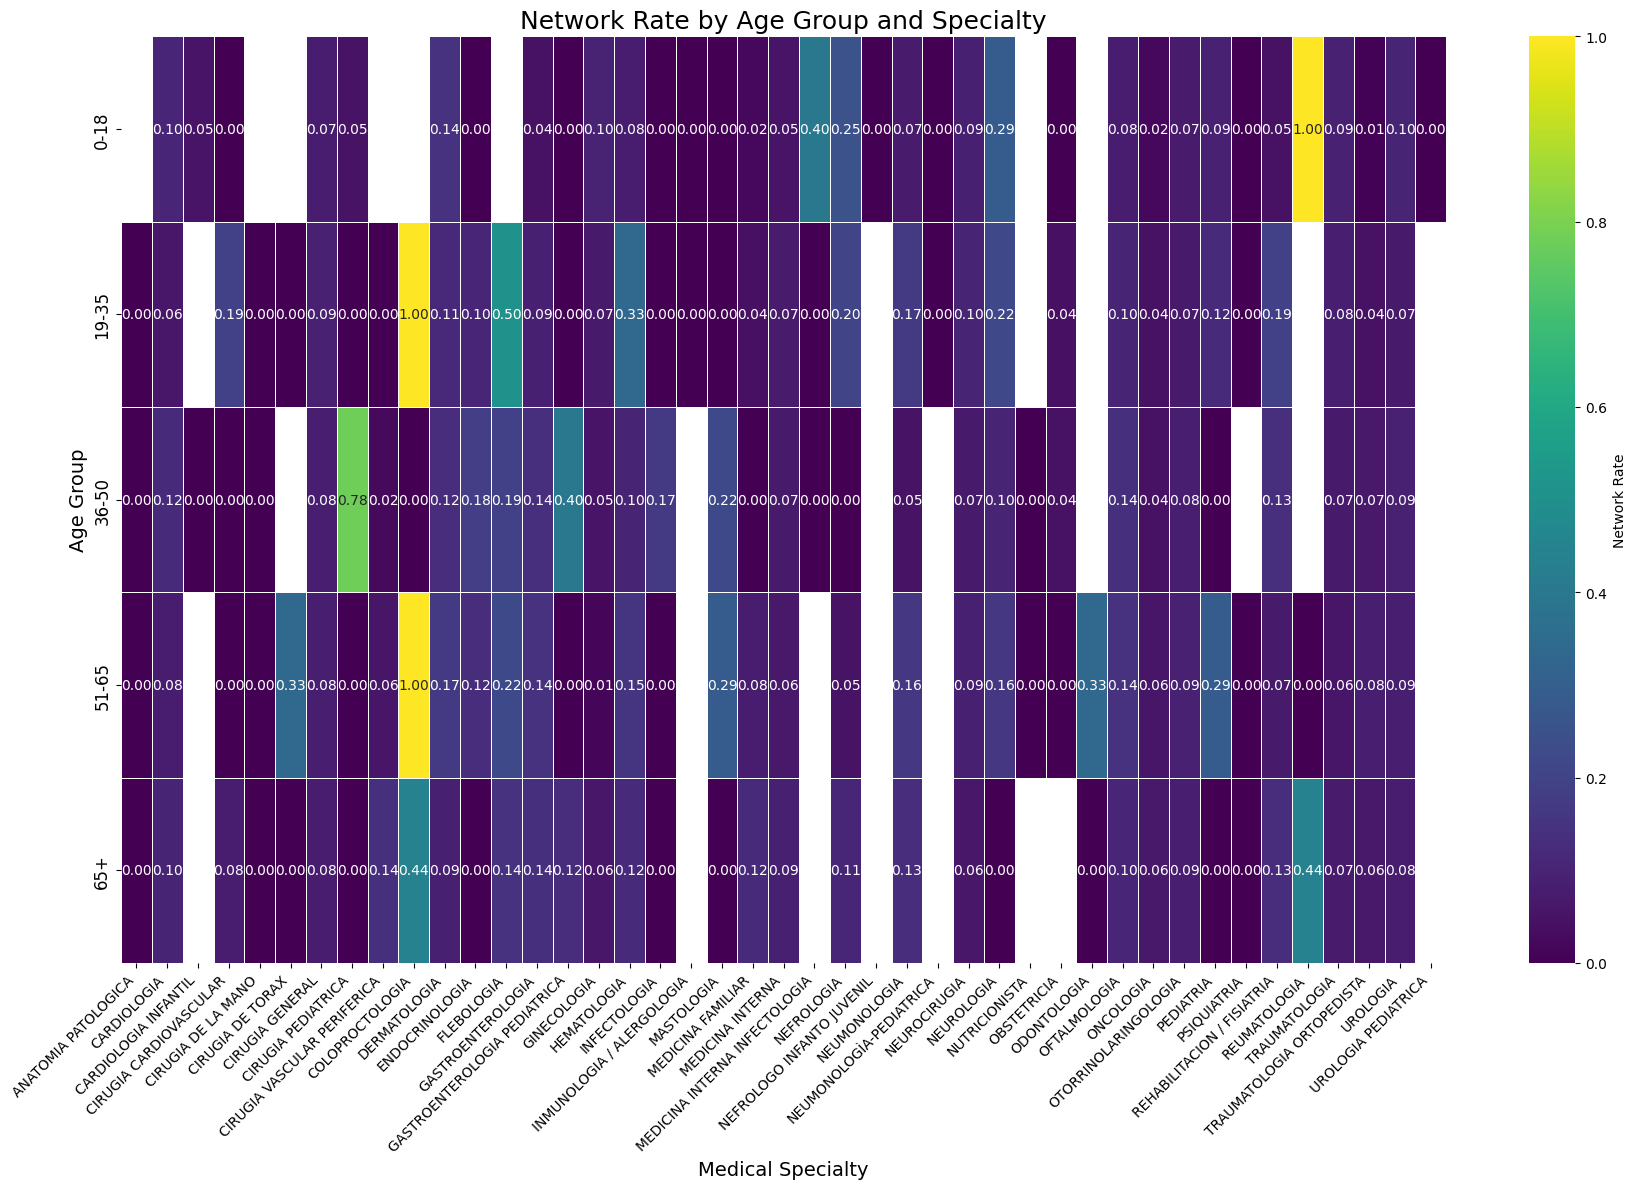

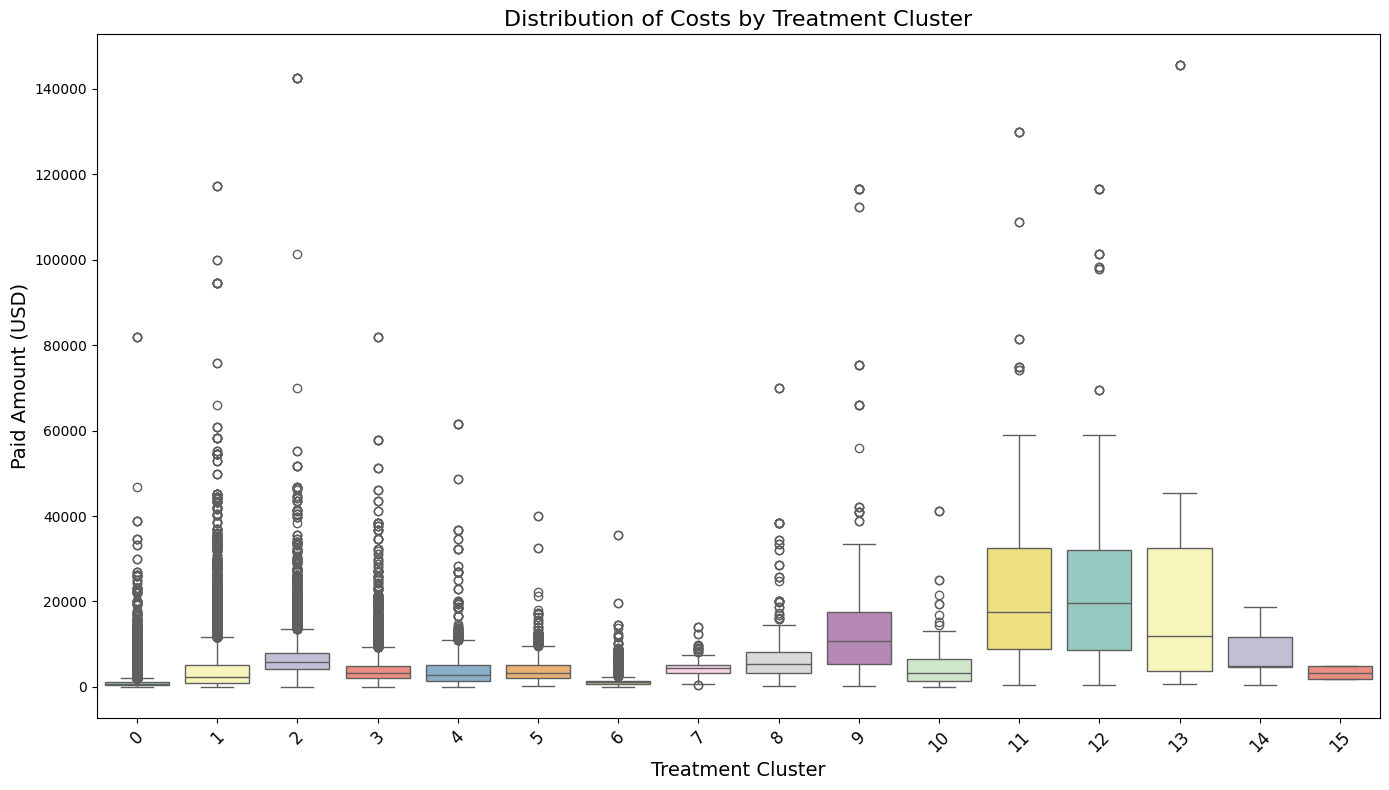

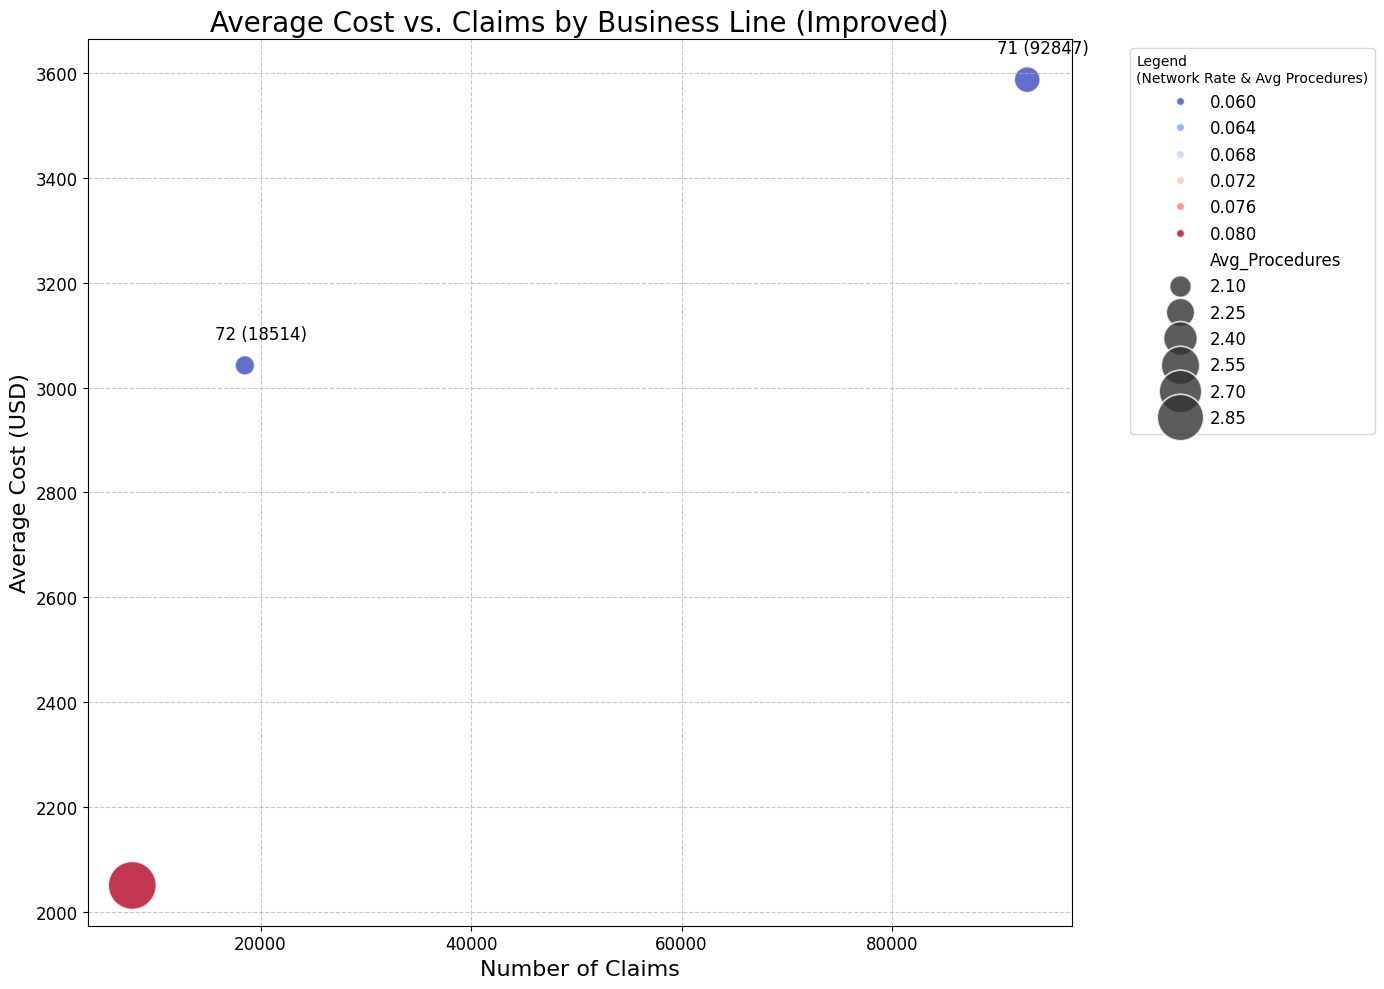

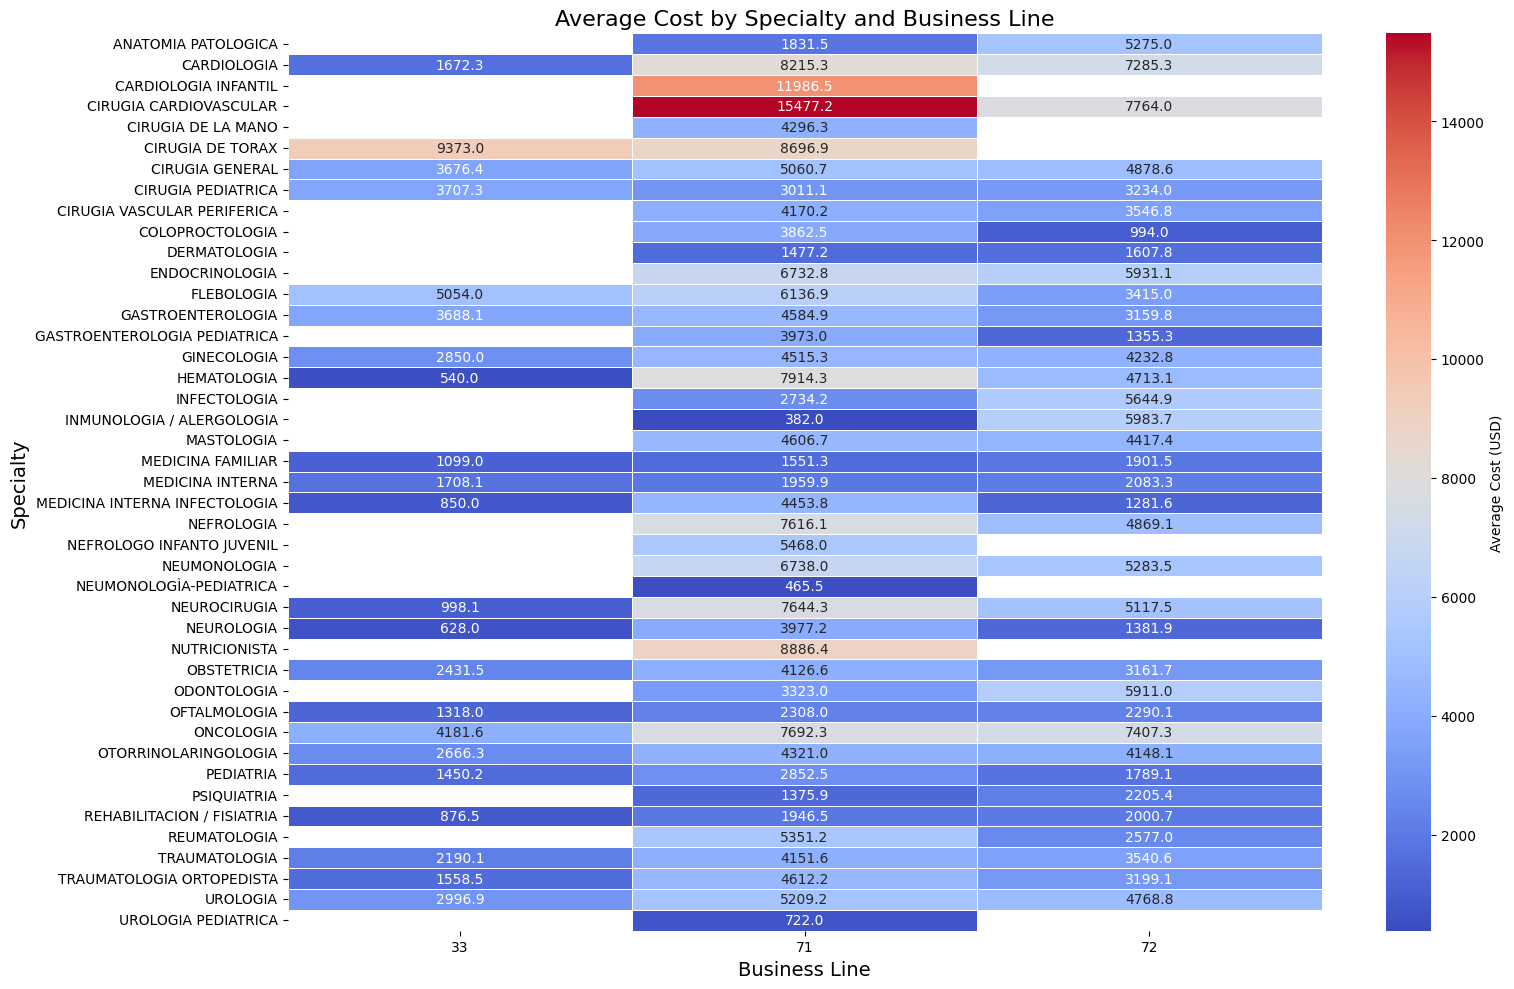

In [47]:
# Run the extended analysis and capture results
extended_results = analyze_extended_metrics()
df_extended = extended_results['df_extended']  # Ensure df_extended is available

# Visualization for Extended Analysis

# 1. Medical Specialty Analysis
# Bar Chart for Network Rate by Specialty
plt.figure(figsize=(12, 8))
network_impact = extended_results['specialty_metrics']['network_rate'].sort_values(ascending=False)

sns.barplot(
    y=network_impact.index,
    x=network_impact.values,
    palette='coolwarm'
)
plt.title('Network Rate by Specialty', fontsize=16)
plt.xlabel('Network Rate', fontsize=14)
plt.ylabel('Medical Specialty', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Demographics Analysis
# Heatmap for Network Rate by Age Group and Specialty
age_specialty_data = (
    df_extended.groupby(['AGE_GROUP', 'SPECIALTY'], observed=False)['IN_RED']
    .mean()
    .reset_index()
    .pivot(index='AGE_GROUP', columns='SPECIALTY', values='IN_RED')  # Corrected pivot
)
plt.figure(figsize=(18, 12))
sns.heatmap(
    age_specialty_data,
    cmap='viridis',
    annot=True,  # Display exact values
    fmt='.2f',   # Limit decimals for annotations
    linewidths=0.5,
    cbar_kws={'label': 'Network Rate'}
)
plt.title('Network Rate by Age Group and Specialty', fontsize=18)
plt.xlabel('Medical Specialty', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels and align
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 3. Treatment Pattern Analysis
# Boxplot of Costs by Treatment Cluster
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='TREATMENT_CLUSTER',
    y='PAID_USD',
    data=df_extended,
    palette='Set3'
)
plt.title('Distribution of Costs by Treatment Cluster', fontsize=16)
plt.xlabel('Treatment Cluster', fontsize=14)
plt.ylabel('Paid Amount (USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# 4. Business Line Analysis
# Scatter Plot: Avg Cost vs. Claims by Business Line
business_metrics = extended_results['business_metrics']
plt.figure(figsize=(14, 10))

scatter = sns.scatterplot(
    x='Claims',
    y='Avg_Cost',
    size='Avg_Procedures',
    hue='Network_Rate',
    data=business_metrics,
    sizes=(200, 1200),
    palette='coolwarm',
    alpha=0.8,
    legend='brief'
)

# Annotate key points (e.g., outliers or high-impact points)
for i in range(len(business_metrics)):
    if business_metrics['Claims'].iloc[i] > 50000 or business_metrics['Avg_Cost'].iloc[i] > 3000:
        plt.text(
            business_metrics['Claims'].iloc[i] + 1500, 
            business_metrics['Avg_Cost'].iloc[i] + 50,
            f"{business_metrics.index[i]} ({business_metrics['Claims'].iloc[i]})", 
            fontsize=12,
            ha='center'
        )
handles, labels = scatter.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    title='Legend\n(Network Rate & Avg Procedures)',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=12
)
plt.title('Average Cost vs. Claims by Business Line (Improved)', fontsize=20)
plt.xlabel('Number of Claims', fontsize=16)
plt.ylabel('Average Cost (USD)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Cross-Analysis
# Heatmap for Cross-Analysis: Specialty vs. Business Line
cross_analysis = extended_results['cross_analysis']

plt.figure(figsize=(16, 10))
sns.heatmap(
    cross_analysis,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Average Cost (USD)'}
)
plt.title('Average Cost by Specialty and Business Line', fontsize=16)
plt.xlabel('Business Line', fontsize=14)
plt.ylabel('Specialty', fontsize=14)
plt.tight_layout()
plt.show()

## **3 - Customer Stats**
- how much paid after insurance before network vs after network
- distribution of claims by type before network vs after network 

In [48]:
import pandas as pd
import numpy as np

# Function to calculate percentage change
def calculate_percentage_change(after, before):
    if before == 0 and after != 0:
        return float('inf')  # Infinite increase
    elif before == 0 and after == 0:
        return 0.0  # No change if both are zero
    elif pd.isna(before) or pd.isna(after):
        return float('nan')  # Undefined if either is NaN
    else:
        return ((after - before) / before) * 100

def analyze_client_payment_percentage(clinic_name):
    """
    Analyzes the percentage of claims clients are paying before and after
    a clinic joins the network.
    """
    clinic_data = CLINICS_IN_RED.get(clinic_name)
    if not clinic_data:
        return None

    # Get join date
    join_dates = [pd.to_datetime(d) for d in clinic_data['join_date'].values() if d]
    if not join_dates:
        return None
    join_date = min(join_dates)

    # Get clinic's last transaction date in 2024
    clinic_last_date = df_aggregated[
        (df_aggregated['CLINIC'] == clinic_name) & 
        (df_aggregated['DATE'].dt.year == 2024)
    ]['DATE'].max()
    
    if pd.isnull(clinic_last_date):
        return None

    # Define comparison periods
    after_start = join_date
    after_end = clinic_last_date
    before_start = after_start - pd.DateOffset(years=1)
    before_end = after_end - pd.DateOffset(years=1)

    # Create masks for before and after periods
    after_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= after_start) &
        (df_aggregated['DATE'] <= after_end)
    )
    before_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= before_start) &
        (df_aggregated['DATE'] <= before_end)
    )

    # Get claims for both periods
    after_claims = df_aggregated[after_mask].copy()
    before_claims = df_aggregated[before_mask].copy()

    if len(after_claims) == 0 or len(before_claims) == 0:
        return None

    # Calculate mean client payment percentage for each period
    before_percent = before_claims['CLIENT_USD_PCNT'].mean()
    after_percent = after_claims['CLIENT_USD_PCNT'].mean()

    # Calculate percentage change
    change_percent = calculate_percentage_change(after_percent, before_percent)

    return {
        'clinic': clinic_name,
        'tier': clinic_data.get('tier', 'Unknown'),
        'before_percent': before_percent,
        'after_percent': after_percent,
        'change_percent': change_percent
    }

# Analyze all clinics
payment_percentage_analysis = []
for clinic in CLINICS_IN_RED:
    result = analyze_client_payment_percentage(clinic)
    if result:
        payment_percentage_analysis.append(result)

# Categorize clinics
benefit_clinics = []
burden_clinics = []

for data in payment_percentage_analysis:
    if data['change_percent'] < 0:
        benefit_clinics.append(data)
    elif data['change_percent'] > 0:
        burden_clinics.append(data)

# Display results
print("\nClinics Where Clients Are Benefitting (Paying Less):")
print("-" * 50)
for clinic in benefit_clinics:
    print(f"  {clinic['clinic']} (Tier {clinic['tier']}):")
    print(f"    Before: {clinic['before_percent']:.2f}%")
    print(f"    After: {clinic['after_percent']:.2f}%")
    print(f"    Change: {clinic['change_percent']:.1f}%")

print("\nClinics Where Clients Are Paying More:")
print("-" * 50)
for clinic in burden_clinics:
    print(f"  {clinic['clinic']} (Tier {clinic['tier']}):")
    print(f"    Before: {clinic['before_percent']:.2f}%")
    print(f"    After: {clinic['after_percent']:.2f}%")
    print(f"    Change: {clinic['change_percent']:.1f}%")


Clinics Where Clients Are Benefitting (Paying Less):
--------------------------------------------------
  COMERCIAL CIENTIFICA, C.A. (Tier A):
    Before: 6.54%
    After: 2.83%
    Change: -56.7%
  GRUPO MEDICO SANTA PAULA, S.A. (GMSP S.A.) (Tier A):
    Before: 0.89%
    After: 0.31%
    Change: -64.9%
  POLICLINICA METROPOLITANA, C.A. (Tier A):
    Before: 4.34%
    After: 3.81%
    Change: -12.1%
  UNIDAD OFTALMOLOGICA GONZALEZ SIRIT, C.A. (Tier B):
    Before: 1.49%
    After: 0.01%
    Change: -99.5%

Clinics Where Clients Are Paying More:
--------------------------------------------------
  A.C. CENTRO MEDICO DOCENTE LA TRINIDAD (Tier A):
    Before: 3.30%
    After: 3.33%
    Change: 1.0%
  CENTRO CLINICO FENIX SALUD,C.A. (Tier C):
    Before: 3.15%
    After: 13.78%
    Change: 336.8%
  CENTRO CLINICO VISTA CALIFORNIA, C.A. (Tier C):
    Before: 0.88%
    After: 2.93%
    Change: 232.4%
  CENTRO DIAGNOSTICO DOCENTE LAS MERCEDES, C.A. (Tier B):
    Before: 0.00%
    After: 0.0

In [49]:
# Function to analyze claim type distribution
def analyze_claim_type_distribution(clinic_name):
    """
    Analyzes the distribution of claim types (TYPE) before and after
    a clinic joins the network. Normalizes time frames to account for seasonality.
    """
    clinic_data = CLINICS_IN_RED.get(clinic_name)
    if not clinic_data:
        return None
    
    # Get join date
    join_dates = [pd.to_datetime(d) for d in clinic_data['join_date'].values() if d]
    if not join_dates:
        return None
    join_date = min(join_dates)
    
    # Get clinic's last transaction date in 2024
    clinic_last_date = df_aggregated[
        (df_aggregated['CLINIC'] == clinic_name) & 
        (df_aggregated['DATE'].dt.year == 2024)
    ]['DATE'].max()
    
    if pd.isnull(clinic_last_date):
        return None
    
    # Define comparison periods
    after_start = join_date
    after_end = clinic_last_date
    
    before_start = after_start - pd.DateOffset(years=1)
    before_end = after_end - pd.DateOffset(years=1)
    
    # Get months to compare
    comparison_months = pd.date_range(
        after_start, 
        after_end, 
        freq='ME'
    ).month.unique()
    
    # Create masks for before and after periods
    after_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= after_start) &
        (df_aggregated['DATE'] <= after_end)
    )
    
    before_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= before_start) &
        (df_aggregated['DATE'] <= before_end) &
        (df_aggregated['DATE'].dt.month.isin(comparison_months))  # Same months as after period
    )
    
    # Get claims for both periods
    after_claims = df_aggregated[after_mask].copy()
    before_claims = df_aggregated[before_mask].copy()
    
    if len(after_claims) == 0 or len(before_claims) == 0:
        return None
    
    # Calculate type distributions for each period
    type_distributions = {}
    for period, claims in [('Before', before_claims), ('After', after_claims)]:
        type_distributions[period] = (
            claims['TYPE']
            .value_counts(normalize=True)
            .sort_index()
            .to_dict()
        )
    
    # Calculate percentage changes in type distribution
    all_types = set(type_distributions['Before'].keys()).union(set(type_distributions['After'].keys()))
    changes = {
        claim_type: (
            (type_distributions['After'].get(claim_type, 0) - type_distributions['Before'].get(claim_type, 0)) * 100
        )
        for claim_type in all_types
    }
    
    return {
        'type_distributions': type_distributions,
        'changes': changes,
        'tier': clinic_data.get('tier', 'Unknown'),
        'comparison_period': {
            'before': (before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')),
            'after': (after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')),
            'months_compared': sorted(comparison_months.tolist())
        }
    }

# Analyze all clinics
claim_type_analysis = {}
for clinic in CLINICS_IN_RED:
    result = analyze_claim_type_distribution(clinic)
    if result:
        claim_type_analysis[clinic] = result

# Group clinics based on whether they increase Carta Aval, increase Emergencia, or are neutral
claim_changes = {
    "Increase Carta Aval": [],
    "Increase Emergencia": [],
    "Neutral": []
}

for clinic, data in claim_type_analysis.items():
    changes = data['changes']
    carta_aval_change = changes.get("CARTA AVAL", 0)
    emergencia_change = changes.get("EMERGENCIA", 0)
    
    if carta_aval_change > 0:
        claim_changes["Increase Carta Aval"].append((clinic, carta_aval_change))
    elif emergencia_change > 0:
        claim_changes["Increase Emergencia"].append((clinic, emergencia_change))
    else:
        claim_changes["Neutral"].append(clinic)

# Print grouped results
print("\nGrouped Claim Type Changes")
print("-" * 50)

for category, clinics in claim_changes.items():
    print(f"\n{category}:")
    if category in ["Increase Carta Aval", "Increase Emergencia"]:
        for clinic, change in sorted(clinics, key=lambda x: x[1], reverse=True):
            print(f"  Clinic: {clinic} (Change: {change:+.1f}%)")
    else:  # Neutral case
        for clinic in clinics:
            print(f"  Clinic: {clinic}")


Grouped Claim Type Changes
--------------------------------------------------

Increase Carta Aval:
  Clinic: A.C. CENTRO MEDICO DOCENTE LA TRINIDAD (Change: +8.2%)
  Clinic: GRUPO MEDICO LAS ACACIAS, C.A. (Change: +5.0%)
  Clinic: CLINICA VISTA ALEGRE C A (Change: +4.7%)
  Clinic: CLINICA PIEDRA AZUL, C.A. (Change: +2.7%)
  Clinic: SERVICIOS CLINICOS U.M.Q. NUEVA CARACAS , C.A (Change: +1.2%)

Increase Emergencia:
  Clinic: SERVICIOS CLINICOS SANTA MONICA, C.A. (Change: +5.1%)
  Clinic: CENTRO CLINICO FENIX SALUD,C.A. (Change: +5.0%)
  Clinic: COMERCIAL CIENTIFICA, C.A. (Change: +4.6%)
  Clinic: GRUPO MEDICO VARGAS, C.A. (Change: +2.7%)
  Clinic: CENTRO CLINICO VISTA CALIFORNIA, C.A. (Change: +2.6%)
  Clinic: CENTRO MEDICO LOIRA, C.A. (Change: +2.2%)

Neutral:
  Clinic: CENTRO DIAGNOSTICO DOCENTE LAS MERCEDES, C.A.
  Clinic: CENTRO MEDICO INTEGRA, C.A.
  Clinic: UNIDAD OFTALMOLOGICA DE CARACAS, C.A
  Clinic: UNIDAD OFTALMOLOGICA GONZALEZ SIRIT, C.A.


In [55]:
import pandas as pd
import statsmodels.api as sm

# Multivariate Analysis
df_aggregated['IN_RED'] = df_aggregated['IN_RED'].astype(int)
X_1 = df_aggregated[['IN_RED', 'CLAIM_USD']]
y_1 = df_aggregated['CLIENT_USD']
X_1 = sm.add_constant(X_1)

model_1 = sm.OLS(y_1, X_1).fit()

# Multivariate results
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:             CLIENT_USD   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.624e+05
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:13:53   Log-Likelihood:            -5.3890e+05
No. Observations:               55717   AIC:                         1.078e+06
Df Residuals:                   55714   BIC:                         1.078e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2511.4053     17.354   -144.717      0.0

In [53]:
# Multivariate Analysis
df_aggregated['IN_RED'] = df_aggregated['IN_RED'].astype(int)
X_2 = df_aggregated[['IN_RED', 'CLAIM_USD']]
y_2 = df_aggregated['PAID_USD']
X_2 = sm.add_constant(X_2)

model_2 = sm.OLS(y_2, X_2).fit()

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               PAID_USD   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3720.
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:50:53   Log-Likelihood:            -5.3896e+05
No. Observations:               55717   AIC:                         1.078e+06
Df Residuals:                   55714   BIC:                         1.078e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2518.5450     17.374    144.957      0.0